## **BUSINESS UNDERSTANDING**
**Introduction**
This project focuses on time series forecasting to predict store sales for Corporation Favorita, a large Ecuadorian-based grocery retailer. The objective is to build a model that accurately predicts the unit sales for thousands of items sold at different Favorita stores.
This is a time series regression analysis problem.

**GOALS**
1. Predict store sales on data from Corporation Favorita.
2. Forecast the demand of products in various locations.

**Methodology**
To achieve the objectives, we will follow a structured approach:

Data Exploration: Thoroughly explore the provided datasets to understand the available features, their distributions, and relationships. This step will provide initial insights into the store sales data and help identify any data quality issues.

Data Preparation: Handle missing values, perform feature engineering, and encode categorical variables as necessary. This step may involve techniques like imputation, scaling, and one-hot encoding.

Time Series Analysis: Analyze the temporal aspects of the data, including trends, seasonality, and potential outliers. This analysis will provide a deeper understanding of the underlying patterns in store sales over time.

Model Selection and Training: Select appropriate time series forecasting models and train them using the prepared data. Consider incorporating external factors like promotions, holidays, and oil prices, if available, to enhance the forecasting accuracy.

Model Evaluation: Evaluate the trained models using appropriate metrics, such as mean absolute error (MAE), root mean squared error (RMSE), or mean absolute percentage error (MAPE). Assess the models' performance and identify the most accurate and reliable forecasting model.

Model Deployment and Forecasting: Deploy the chosen model to predict store sales for future time periods, leveraging the provided test dataset. Generate forecasts for the target period and assess the model's ability to capture the sales patterns accurately.

By following this methodology, we aim t

**NOTICE**

Wages in the public sector are paid every two weeks on the 15th and on the last day of the month. Supermarket sales could be affected by this.

A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was celebrated, look for the corresponding row where type is Transfer.

Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

**TASK**

Build a model that more accurately predicts the unit sales for thousands of items sold at different Favorita stores.

**HYPOTHESIS**

*NULL HYPOTHESIS* - 
Promotional activities does not have a significant effect on store sales

*ALTERNATIVE HYPOTHESIS* - 
Promotional activities does have a significant effect on store sales


**Analytical Questions** 

1. Is the train dataset complete (has all the required dates)?
2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
3. Compare the sales for each month across the years and determine which month of which year had the highest sales.
4. Did the earthquake impact sales?
5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
6. Are sales affected by promotions, oil prices and holidays?
7. What analysis can we get from the date and its extractable features?
8. Which product family and stores did the promotions affect.
9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.

In [1]:
## IMPORT LIBRARIES 
import pyodbc    
from dotenv import dotenv_values
import pandas as pd
import numpy as np
import os
import joblib
import warnings 
import calendar
import datetime as dt
from itertools import product

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',None)
pd.options.display.float_format='{:.2f}'.format

## Import visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

## Statistical analysis
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, zivot_andrews
from scipy.stats import kendalltau,ttest_ind

## MODELLING 
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_squared_log_error
from pmdarima import auto_arima
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression

## Evaluation
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV,GridSearchCV
from sklearn.metrics import make_scorer

## feature importance
from sklearn.inspection import permutation_importance
from xgboost import plot_importance, plot_tree

In [2]:
## Data environment access
# Load environment variables from .env file into a dictionary
environment_variables=dotenv_values('.env')


# Get the values for the credentials you set in the '.env' 
database=environment_variables.get("DATABASE")
server=environment_variables.get("SERVER")
username=environment_variables.get("USERNAME")
password=environment_variables.get("PASSWORD")


connection_string= f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [3]:
# connect your data using pyodbc
connection=pyodbc.connect(connection_string)

## **DATA UNDERSTANDING**

**TASKS** 
1. Load all datasets 
2. Perform an EDA 
3. Check for the quality of data 
4. Merge your dataset.
5. Answer your analytical questions 

#### **FEATURE COLUMNS**

| Feature | Definition|
|----|--------|
| Date | The date at which sales have been made or transactions|
| Store_nbr| Identifies the store at which products are being sold|
| Family | Identifies the type of product sold|
| Sales| The total sale of a particular family product|
|On promotion| The family product was on promotion(discounted)|
|Transaction| sales made on a specific date|
|City | Location of the stores|
| State | State in which the stores are located|
|Cluster| Grouping of similar stores|
|Daily oil price| Price of oil |
|Type| Refers to the type of day(holiday, bridge, workday)|
|Transfer| Refers to a moved date/holiday set to another date|
|Locale| Refers to the location a holiday is being celebrated(local,regional,national)|
|Locale_name| The name of the location|
|Description| Describes the date or holiday|

DAILY OIL PRICE DATASET

In [4]:
query = "Select * from dbo.oil"

d1 = pd.read_sql(query, connection,parse_dates=["date"])
d1.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


**EDA**

In [5]:
d1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [6]:
d1.isna().sum()

date           0
dcoilwtico    43
dtype: int64

In [7]:
d1.duplicated().sum()

0

In [8]:
d1.describe(include="all").T

,count,mean,min,25%,50%,75%,max,std
date,1218,2015-05-02 12:00:00,2013-01-01 00:00:00,2014-03-03 06:00:00,2015-05-02 12:00:00,2016-06-30 18:00:00,2017-08-31 00:00:00,NaN
dcoilwtico,1175.00,67.71,26.19,46.41,53.19,95.66,110.62,25.63


**OBSERVATIONS**
1. There are missing variables on dcoilwtico with 43 NaN values
2. For our first dataset the mean of dcoilwtico is 67.71, with a std deviation of 25.63
3. The mean of our dates holds at 2015 with a median at 2015.
4. In the period of 2013 the price of oil was higher followed with 2014.However,in between 2014 and 2015 the prices went down with seasonality following in 2016 to 2017 increasing a bit.

**ACTION**
1. Clean the missing values in the column with interpolation.
2. Check for missing dates in the column and clean.

**DATA CLEANING**

In [9]:
# Generate a sequence of dates for the desired range and frequency
oil_dates = pd.date_range(start=d1.index.min(), end=d1.index.max(), freq='D')

# Check if all dates in the new_dates sequence are present in the df timeseries
missing_oil_dates = oil_dates[~oil_dates.isin(d1.index)]

# Print the missing dates
print(f"Total_missing_oil_dates: {missing_oil_dates}")

Total_missing_oil_dates: DatetimeIndex(['1970-01-01'], dtype='datetime64[ns]', freq='D')


In [10]:
oil_data = d1.reindex(oil_dates)

oil_data = oil_data.rename_axis('date')

print(oil_data)

           date  dcoilwtico
date                       
1970-01-01  NaT         NaN


In [11]:
## Clean the missing value in the column
oil_data= oil_data.interpolate(limit_direction="both")

In [12]:
excess_oil_days= oil_data[oil_data.index >"2017-08-15"]
oil_data.drop(excess_oil_days.index, axis=0)

,date,dcoilwtico
date,,
1970-01-01,NaT,NaN


HOLIDAY DATASET

In [13]:
query = "Select * from dbo.holidays_events"

d2 = pd.read_sql(query, connection,parse_dates=["date"])
d2.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


**EDA**

In [14]:
d2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [15]:
d2.isna().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [16]:
d2.duplicated().sum()

0

In [17]:
d2.describe(include="all").T

,count,unique,top,freq,mean,min,25%,50%,75%,max
date,350,NaN,NaN,NaN,2015-04-24 00:45:15.428571392,2012-03-02 00:00:00,2013-12-23 06:00:00,2015-06-08 00:00:00,2016-07-03 00:00:00,2017-12-26 00:00:00
type,350,6,Holiday,221,NaN,NaN,NaN,NaN,NaN,NaN
locale,350,3,National,174,NaN,NaN,NaN,NaN,NaN,NaN
locale_name,350,24,Ecuador,174,NaN,NaN,NaN,NaN,NaN,NaN
description,350,103,Carnaval,10,NaN,NaN,NaN,NaN,NaN,NaN
transferred,350,2,False,338,NaN,NaN,NaN,NaN,NaN,NaN


**OBSERVATIONS**
1. There are no missing values in our dataset 
2. For this dataset the most frequent in our type column is Holiday, with Locale: National, with Locale_name: Ecuador, with description:Carnval and transfered:False.
3. 2015 is our average date and our most frequent date in the dataset.

STORES BY LOCATION

In [18]:
query = "Select * from dbo.stores"

d3 = pd.read_sql(query, connection)
d3.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


**EDA**

In [19]:
d3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [20]:
d3.isna().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [21]:
d3.duplicated().sum()

0

In [22]:
d3.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
store_nbr,54.00,NaN,NaN,NaN,27.50,15.73,1.00,14.25,27.50,40.75,54.00
city,54,22,Quito,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
state,54,16,Pichincha,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type,54,5,D,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cluster,54.00,NaN,NaN,NaN,8.48,4.69,1.00,4.00,8.50,13.00,17.00


TRANSACTION DATASET

In [23]:
d4 = pd.read_csv(r"Data\transactions.csv",parse_dates=["date"])
d4.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


**EDA**

In [24]:
d4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [25]:
d4.isna().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [26]:
d4.duplicated().sum()

0

In [27]:
d4.describe(include="all").T

,count,mean,min,25%,50%,75%,max,std
date,83488,2015-05-20 16:07:40.866232064,2013-01-01 00:00:00,2014-03-27 00:00:00,2015-06-08 00:00:00,2016-07-14 06:00:00,2017-08-15 00:00:00,NaN
store_nbr,83488.00,26.94,1.00,13.00,27.00,40.00,54.00,15.61
transactions,83488.00,1694.60,5.00,1046.00,1393.00,2079.00,8359.00,963.29


**OBSERVATIONS**
1. Our most frequent date is 2015 May.
2. The average store number ranges at 26.93 with a standard deviation of 15.60 and median of 27.0
3. The average transactions amount to 1694.60 with a standard deviation of 963.28 and median of 1393
4. There are no missing values in our dataset
5. Store number 44 had the highest daily transactions leading at 7273093

TRAIN DATASET

In [28]:
train_data = pd.read_csv(r"Data\train.csv",parse_dates=["date"])
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0
1,1,2013-01-01,1,BABY CARE,0.00,0
2,2,2013-01-01,1,BEAUTY,0.00,0
3,3,2013-01-01,1,BEVERAGES,0.00,0
4,4,2013-01-01,1,BOOKS,0.00,0


**EDA**

In [29]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [30]:
train_data.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [31]:
train_data.duplicated().sum()

0

In [32]:
train_data.describe(include="all").T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
id,3000888.00,NaN,NaN,NaN,1500443.50,0.00,750221.75,1500443.50,2250665.25,3000887.00,866281.89
date,3000888,NaN,NaN,NaN,2015-04-24 08:27:04.703088384,2013-01-01 00:00:00,2014-02-26 18:00:00,2015-04-24 12:00:00,2016-06-19 06:00:00,2017-08-15 00:00:00,NaN
store_nbr,3000888.00,NaN,NaN,NaN,27.50,1.00,14.00,27.50,41.00,54.00,15.59
family,3000888,33,AUTOMOTIVE,90936,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sales,3000888.00,NaN,NaN,NaN,357.78,0.00,0.00,11.00,195.85,124717.00,1102.00
onpromotion,3000888.00,NaN,NaN,NaN,2.60,0.00,0.00,0.00,0.00,741.00,12.22


In [33]:
families= train_data["family"].unique()
families

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [34]:
stores= train_data["store_nbr"].unique()
stores

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9], dtype=int64)

**OBSERVATIONS**
1. For our dates 2015 seems to be the most frequent year with traffic especially on May.
2. The average store number is 27.5 with a standard deviation of 15.58.
3. Most purchased family was automotive with 33 unique values.
4. The average sales made were amounting to 357.77 wit a standard deviation of 1101.99 and a median of 11.0
5. On promotions the average mean ranged at 2.60277 with a standard deviation of 12.21

**Q1. IS OUR TRAIN DATASET COMPLETE(HAS ALL THE REQUIRED DATES)**

In [35]:
# Generate a sequence of dates for the desired range and frequency
new_dates = pd.date_range(start=train_data["date"].min(), end=train_data["date"].max(), freq='D')

# Check if all dates in the new_dates sequence are present in the df timeseries
missing_dates = new_dates[~new_dates.isin(train_data["date"])]

# Print the missing dates
print(missing_dates)

DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


FILLING THE MISSING DATES AND CLEAN THE DATASETS

In [36]:
## Create a new dataframe that contains the missing dates and the corresponding columns
missing_data_points= product(missing_dates,stores,families)
new_data= pd.DataFrame(data=missing_data_points, columns=["date","store_nbr", "family"])

## Proceed to concat your new dataset to the original data and set index.
train_data=pd.concat([train_data,new_data], axis=0)
train_data.set_index("date", inplace=True)

In [37]:
## Fill in the missing nan values generated from the concatenation
train_data["sales"]= train_data["sales"].fillna(0)
train_data["onpromotion"]= train_data["onpromotion"].fillna(0)
train_data["id"]=train_data["id"].interpolate()

#### **DATA VISUALIZATION**

**UNIVARIATE ANALYSIS**

In [38]:
## Check for the skewness of data
train_data.drop(["family"],axis=1).skew()

id            -0.00
store_nbr      0.00
sales          7.37
onpromotion   11.18
dtype: float64

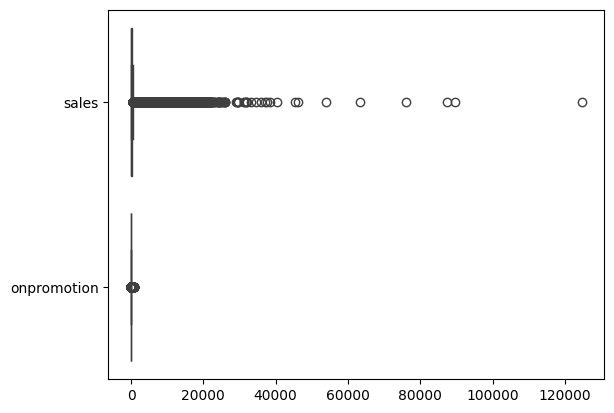

In [39]:
sns.boxplot(train_data.drop(["id","store_nbr"], axis=1),orient="h")
plt.show()

**BIVARIATE ANALYSIS**

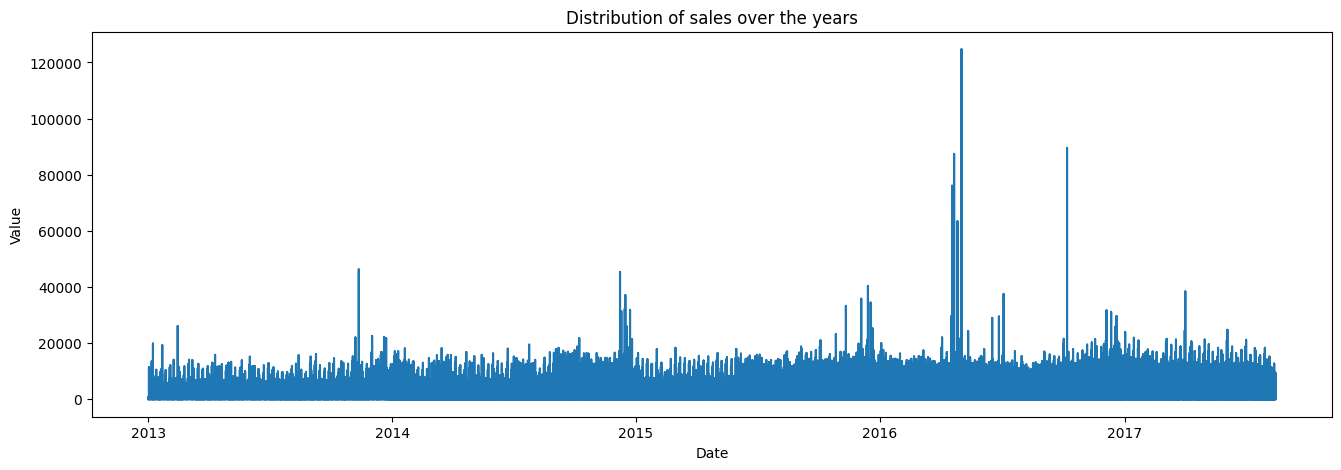

In [40]:
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(train_data, x=train_data.index, y=train_data["sales"], title='Distribution of sales over the years')    

In [41]:
## check for the highest sales by product
product_sales= train_data.groupby("family")["sales"].sum().rename("Totalsales").reset_index()
top_products= product_sales.nlargest(10, "Totalsales")
top_products

,family,Totalsales
12,GROCERY I,343462734.89
3,BEVERAGES,216954486.00
30,PRODUCE,122704684.68
7,CLEANING,97521289.00
8,DAIRY,64487709.00
5,BREAD/BAKERY,42133945.58
28,POULTRY,31876004.47
24,MEATS,31086468.40
25,PERSONAL CARE,24592051.00
9,DELI,24110322.47


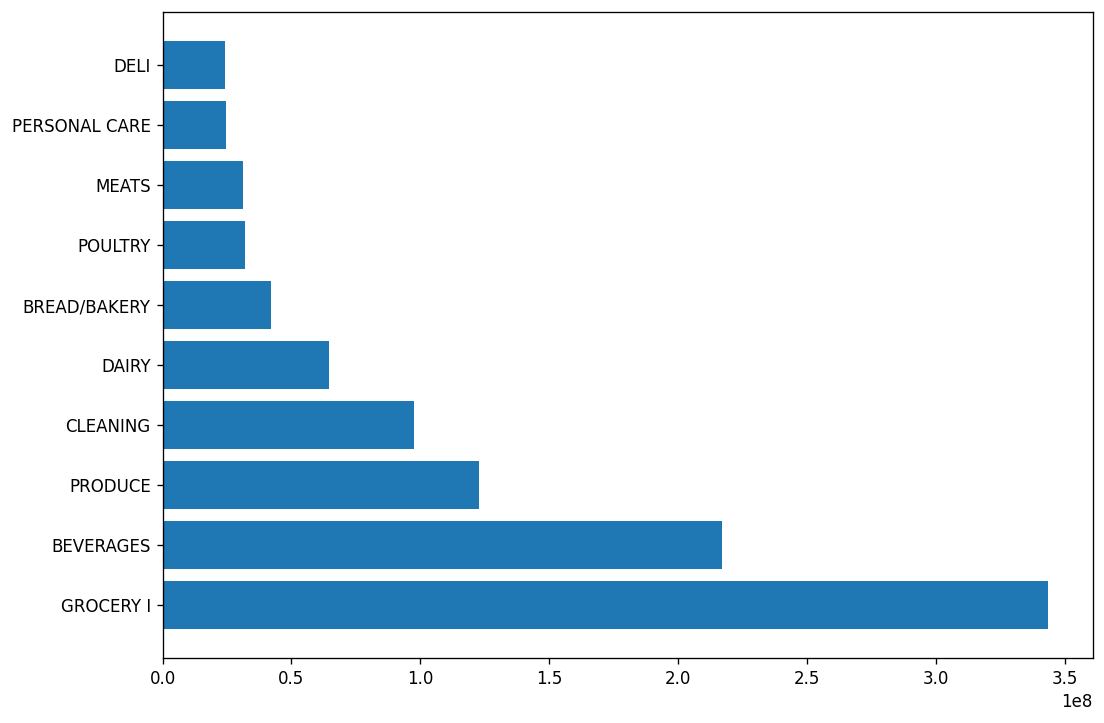

In [42]:
plt.barh(top_products["family"], top_products["Totalsales"])
plt.show()

**MULTIVARIATE ANALYSIS**

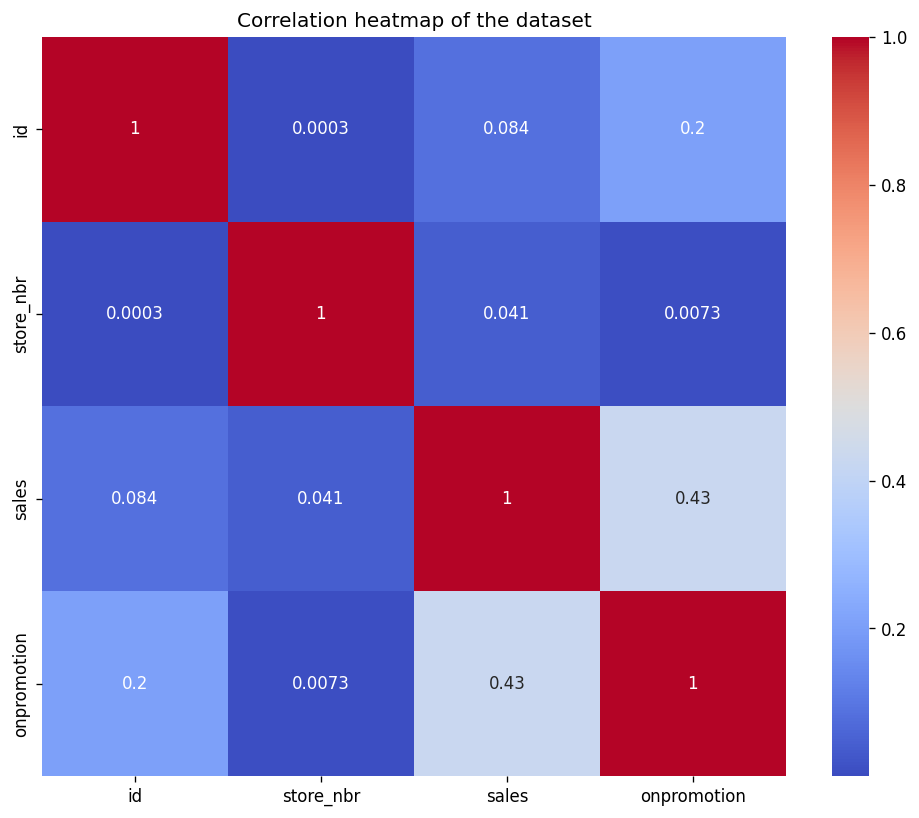

In [43]:
# The correlation of numeric values 
correlation_matrix = train_data.corr(numeric_only= True)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation heatmap of the dataset")
plt.show()

In [44]:
def create_features(df):
    df["year"]= df.index.year
    df["month"]= df.index.month
    df["quater"]= df.index.quarter
    df["dayofmonth"]= df.index.day
    df["dayoftheweek"]=df.index.weekday
    df['Is_Weekend'] = df['dayoftheweek'].isin([5, 6])
    
    return df

In [45]:
## Extract features 
df = create_features(train_data)

#### **DECOMPOSITION**

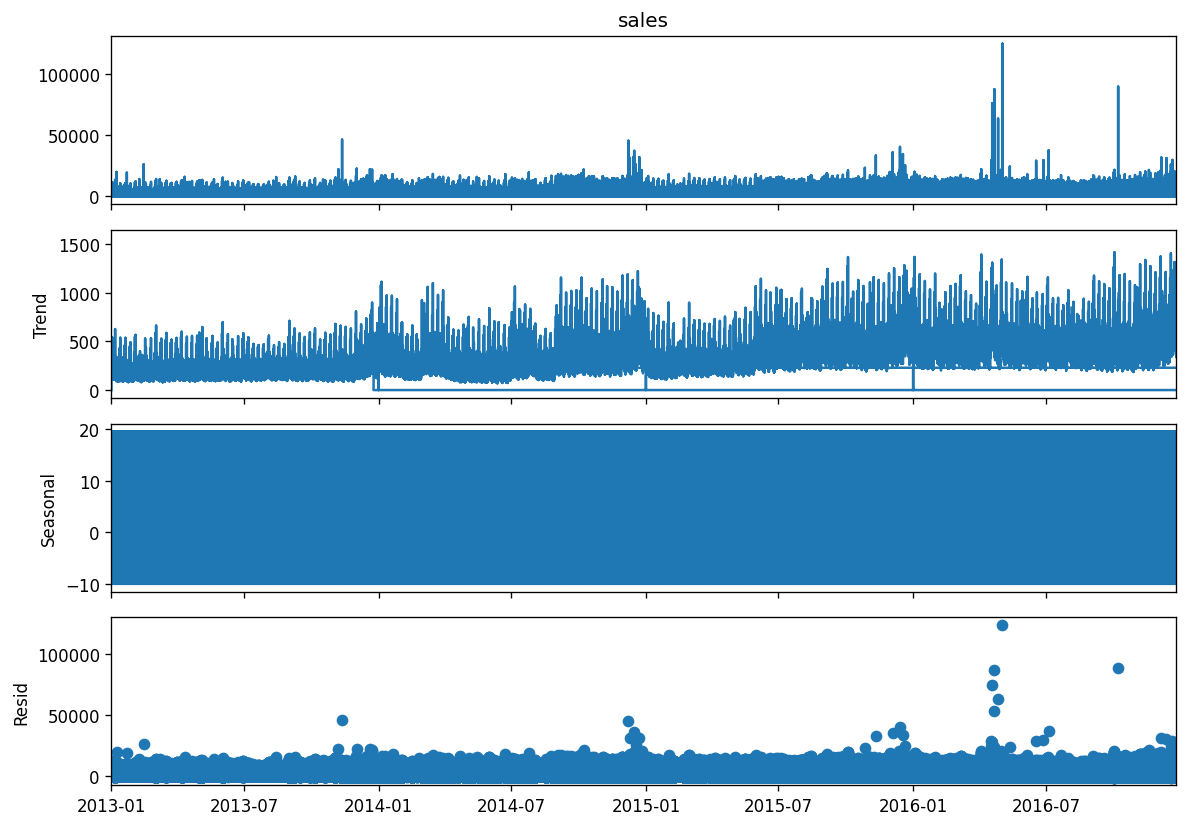

In [46]:
sd = seasonal_decompose(train_data["sales"],model="additive", period=365)
sd.plot()
plt.show()

**PARAMETRIC TESTS**

In [47]:
## Downsample the data to weekly averages
weekly_sales = train_data['sales'].resample('W').mean() # resample weekly and calculate mean
print(weekly_sales)

## test for unit root mean
t_stat, p_value, _, _, critical_values, _  = adfuller(weekly_sales.values, autolag='AIC')
print(f'ADF Statistic: {t_stat:.2f}')
for key, value in critical_values.items():
     print('Critial Values:')
     print(f'   {key}, {value:.2f}')
     
print(f'\np-value: {p_value:.2f}')
print("Non-Stationary") if p_value > 0.05 else print("Stationary")

date
2013-01-06   206.84
2013-01-13   190.29
2013-01-20   189.84
2013-01-27   182.15
2013-02-03   198.56
              ...  
2017-07-23   460.50
2017-07-30   474.73
2017-08-06   513.88
2017-08-13   431.73
2017-08-20   427.49
Freq: W-SUN, Name: sales, Length: 242, dtype: float64
ADF Statistic: -1.48
Critial Values:
   1%, -3.46
Critial Values:
   5%, -2.87
Critial Values:
   10%, -2.57

p-value: 0.54
Non-Stationary


In [48]:
## Check for the stationary 
t_stat, p_value, _, critical_values = kpss(train_data["sales"].values, nlags='auto')

print(f'ADF Statistic: {t_stat:.2f}')
for key, value in critical_values.items():
     print('Critial Values:')
     print(f'   {key}, {value:.2f}')

print(f'\np-value: {p_value:.2f}')
print("Stationary") if p_value > 0.05 else print("Non-Stationary")
warnings.filterwarnings("ignore")

ADF Statistic: 141.82
Critial Values:
   10%, 0.35
Critial Values:
   5%, 0.46
Critial Values:
   2.5%, 0.57
Critial Values:
   1%, 0.74

p-value: 0.01
Non-Stationary


C:\Users\user\AppData\Local\Temp\ipykernel_23176\3048385042.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  t_stat, p_value, _, critical_values = kpss(train_data["sales"].values, nlags='auto')


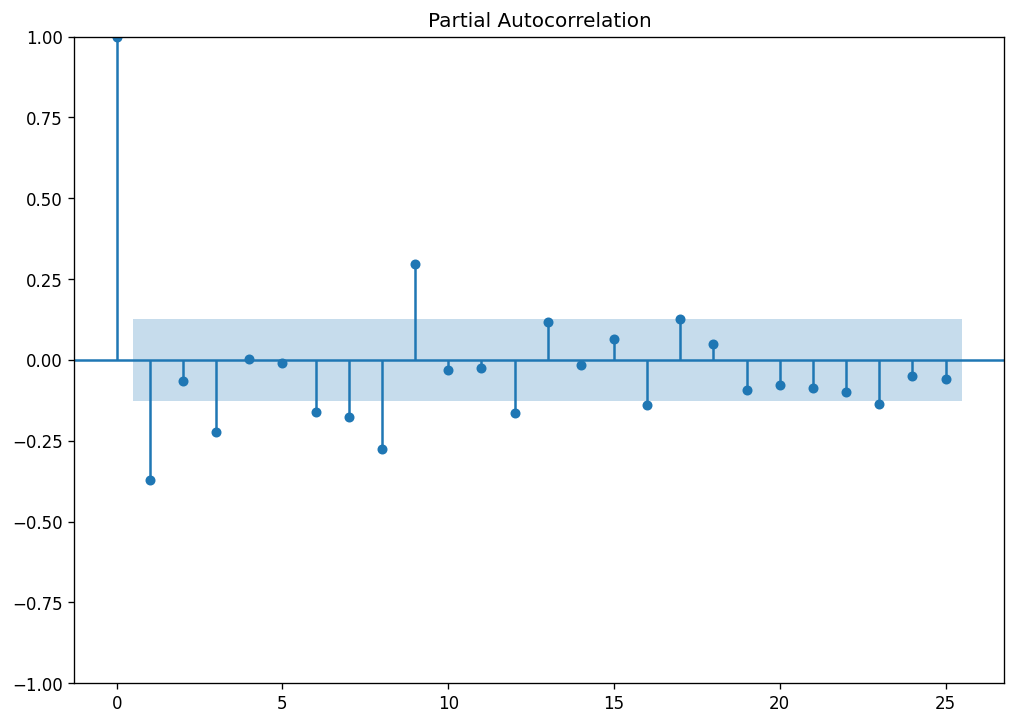

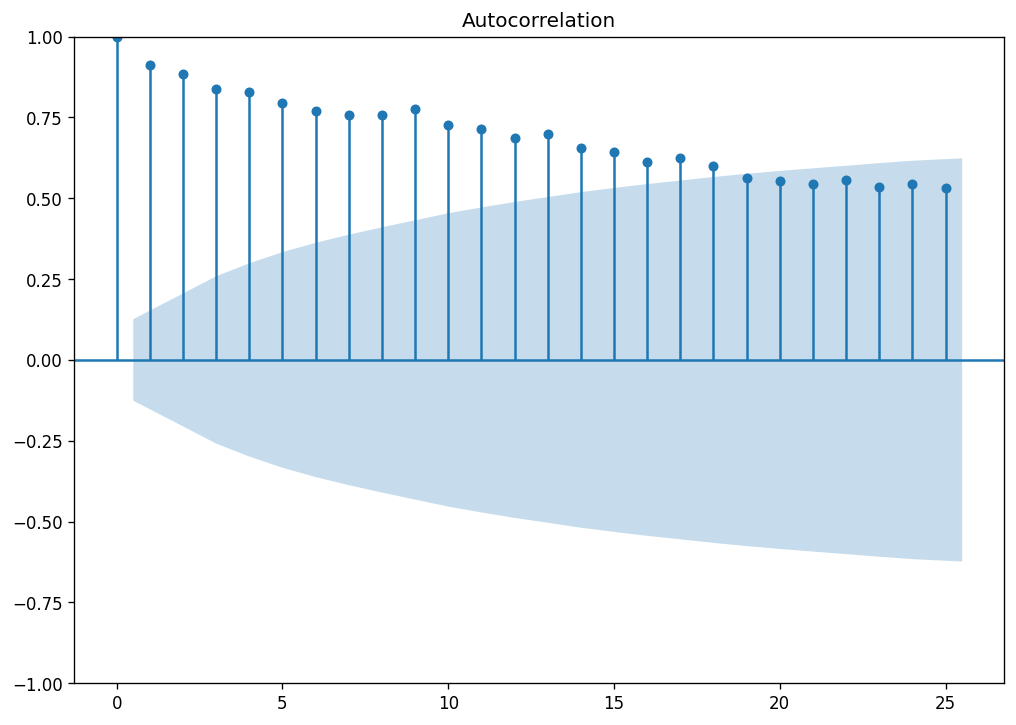

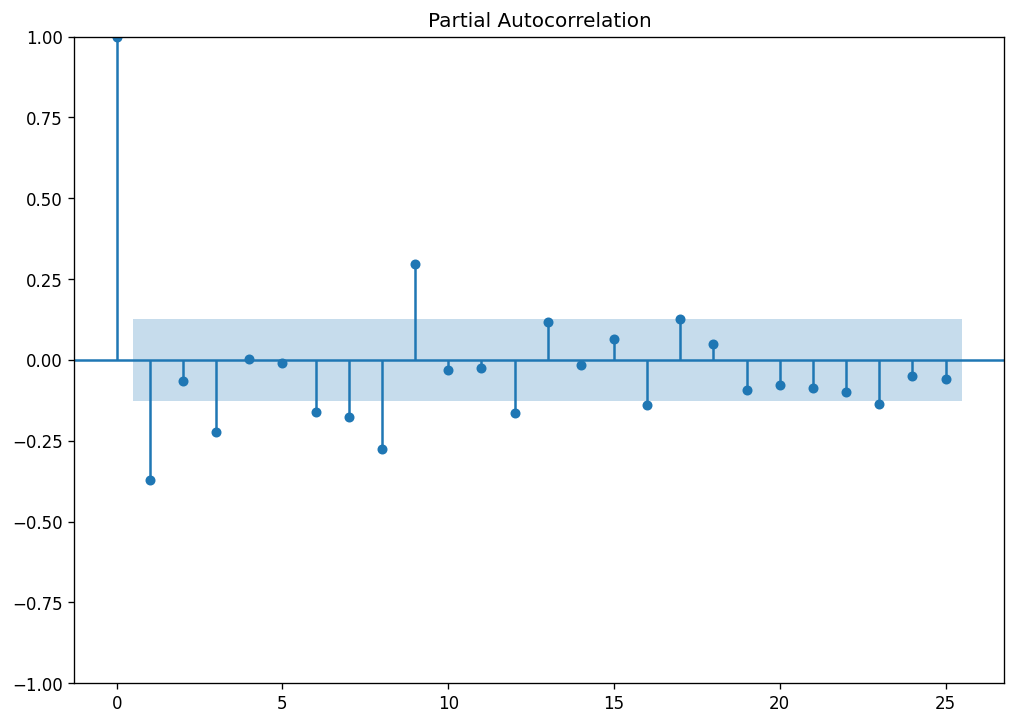

In [49]:
#Check for autocorrelation and partial correlation
plot_acf(weekly_sales, lags=25, alpha=0.05)
plot_pacf(weekly_sales.diff().dropna(), lags=25, alpha=0.05)

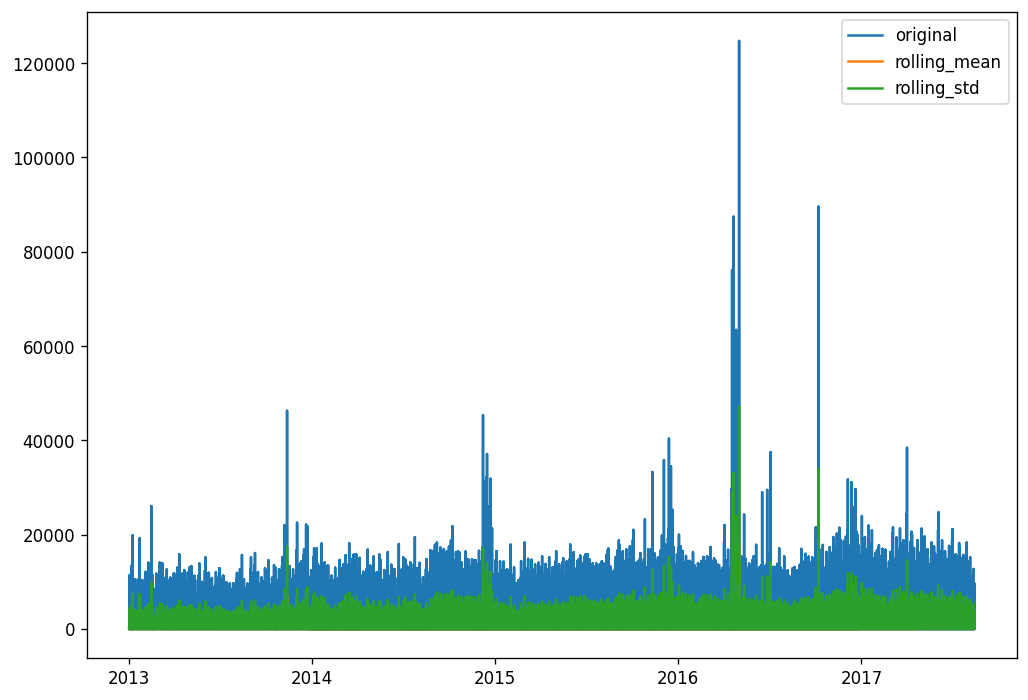

In [50]:
rolling_mean = train_data["sales"].rolling(window=7).mean()
rolling_std= train_data["sales"].rolling(window=7).std()

# visualisation
plt.plot(train_data["sales"], label="original")
plt.plot(rolling_mean, label="rolling_mean")
plt.plot(rolling_std,label="rolling_std")
plt.legend(loc="best")
plt.show()

#### **ANALYTICAL QUESTIONS**

In [51]:
data= (d1,d2,d3,d4,train_data)
for x in data:
    col=x.columns
    print(col)

Index(['date', 'dcoilwtico'], dtype='object')
Index(['date', 'type', 'locale', 'locale_name', 'description', 'transferred'], dtype='object')
Index(['store_nbr', 'city', 'state', 'type', 'cluster'], dtype='object')
Index(['date', 'store_nbr', 'transactions'], dtype='object')
Index(['id', 'store_nbr', 'family', 'sales', 'onpromotion', 'year', 'month',
       'quater', 'dayofmonth', 'dayoftheweek', 'Is_Weekend'],
      dtype='object')


**Q2. WHICH DATES HAVE THE LOWEST AND THE HIGHEST SALES FOR EACH YEAR(EXCLUDING DAYS THE STORE WAS CLOSED)**

In [52]:
## convert date to index
d2= d2.set_index("date")
merge_data= pd.merge(train_data,d2,how="left", left_index=True,right_index=True )

   year  lowest_sales  highest_sales
0  2013          0.12       46271.00
1  2014          0.19       45361.00
2  2015          0.20       40351.46
3  2016          0.40      124717.00
4  2017          0.43       38422.62


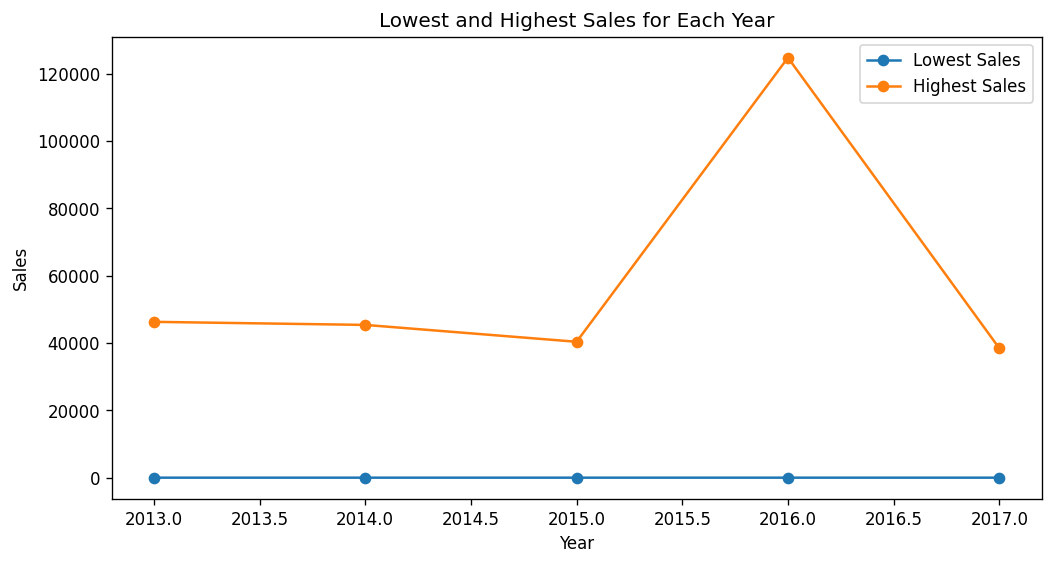

In [53]:
## Create a variable for sales made 
s_m= merge_data[merge_data["sales"]!=0.00]

# Calculate the lowest and highest sales for each year
lowestsales = s_m.groupby(s_m.index.year)['sales'].min().reset_index()
highestsales = s_m.groupby(s_m.index.year)['sales'].max().reset_index()

# Rename columns for clarity
lowestsales.columns = ['year', 'lowest_sales']
highestsales.columns = ['year', 'highest_sales']

# Merge the results
results = pd.merge(lowestsales, highestsales, on='year')

# Print the result
print(results)

# Visualize the results
plt.figure(figsize=(10, 5))
plt.plot(results['year'], results['lowest_sales'], marker='o', label='Lowest Sales')
plt.plot(results['year'], results['highest_sales'], marker='o', label='Highest Sales')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Lowest and Highest Sales for Each Year')
plt.legend()
plt.show()

***REVIEW***

---- From our analysis of the results we can see that 2016 had the highest sales across all the four years with a range of 124717 sales. Followed by 2013 holding at 46271 sales.
Sales decreased significantly in 2017 with 38422 sales.

**Q3 COMPARE SALES FOR EACH MONTH ACROSS YEARS AND DETERMINE WHICH MONTH OF WHICH YEAR HAD THE HIGHEST SALES**

In [54]:
Compare= train_data.groupby([train_data.index.year, train_data.index.month])["sales"].sum()
Compare
Compare= Compare.sort_values(ascending=False)

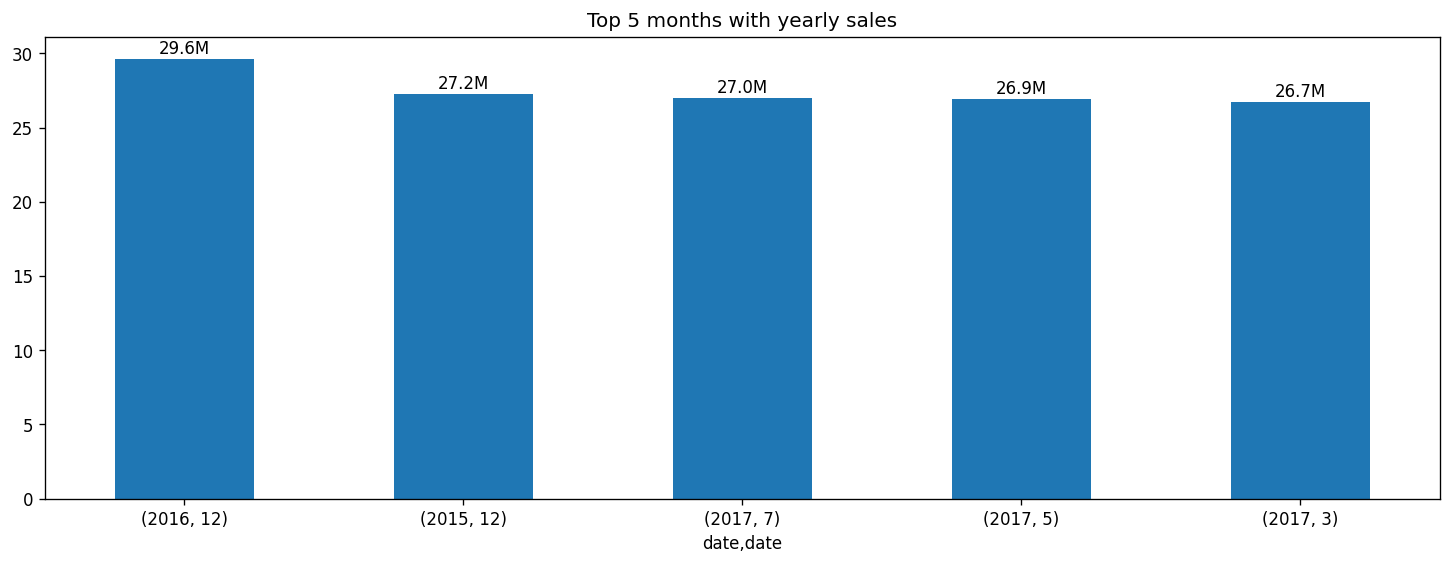

In [55]:
## plotting the monthly sales that were highest for each year
# Convert sales to millions
monthly_sales_millions = Compare / 1000000

plt.figure(figsize=(15, 5))
ax= monthly_sales_millions.head(5).plot.bar()
plt.xticks(rotation=0)
plt.title("Top 5 months with yearly sales")
for i, v in enumerate(monthly_sales_millions.head(5)):
    plt.text(i, v + 0.1, f'{v:.1f}M', ha='center', va='bottom')
plt.show()

***REVIEW***

--- We can see that the sales in December 2016 were the highest across all the months in all the years. Followed by 2015 December. This is attributed to the festivities of the month of December

**Q4 DID THE EARTHQUAKE IMPACT SALES**

Before_After_Earthquake
After    463.04
Before   313.90
Name: sales, dtype: float64


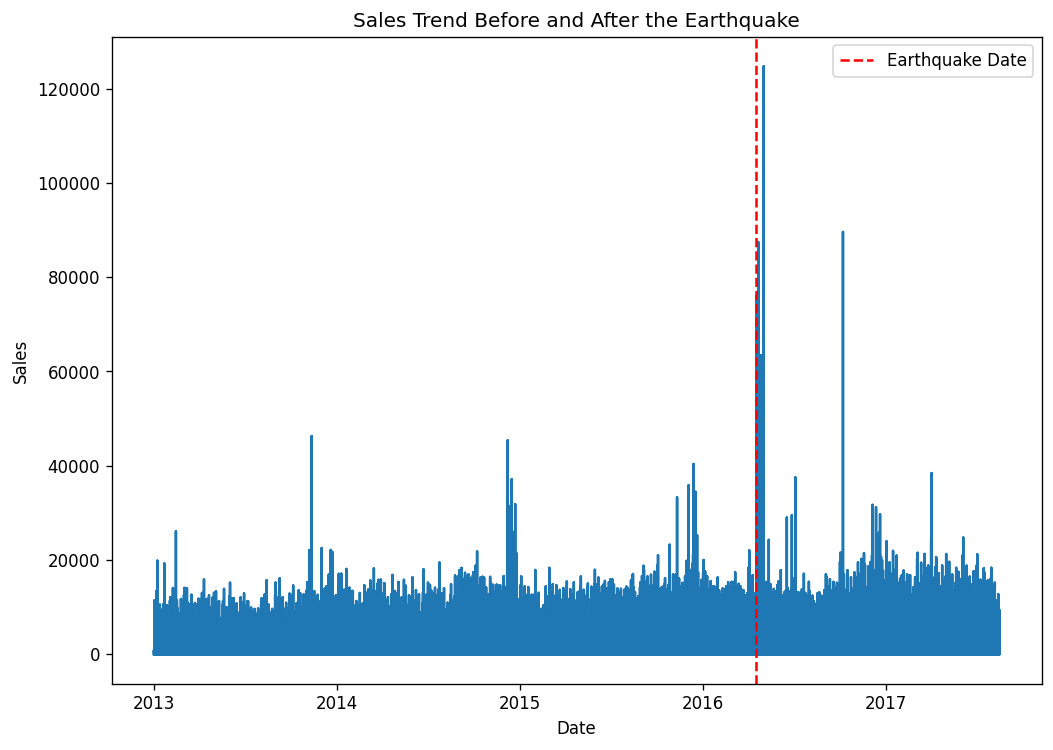

In [56]:
new_data= train_data.copy()

# Set the earthquake date April 16, 2016
earthquake_date = pd.to_datetime('2016-04-16')

# Create a new column to indicate before or after the earthquake
new_data['Before_After_Earthquake'] = np.where(new_data.index < earthquake_date, 'Before', 'After')

# Group the data by Before_After_Earthquake and calculate the mean sales
sales_before_after = new_data.groupby('Before_After_Earthquake')['sales'].mean()

print(sales_before_after)


# Plot the sales trend
plt.plot(new_data.index, new_data['sales'])
plt.axvline(x=earthquake_date, color='red', linestyle='--', label='Earthquake Date')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Trend Before and After the Earthquake')
plt.legend()
plt.show()

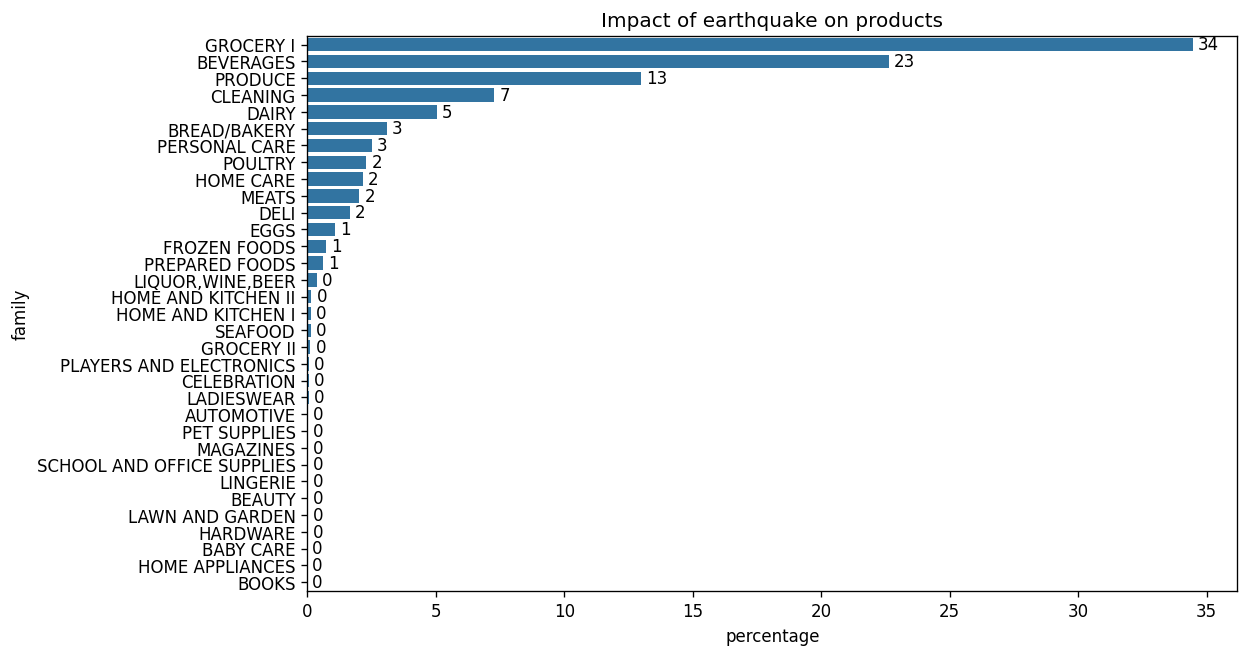

In [57]:
# Filter sales data for the week of the earthquake (2016-04-16)
earthquake_week = new_data[(new_data.index >= earthquake_date - dt.timedelta(days=6)) &
                             (new_data.index <= earthquake_date + dt.timedelta(days=6))]
earthquake_week

# Calculate weekly sales
weekly_sales = earthquake_week.groupby('family')['sales'].sum().rename("impacted").reset_index().sort_values(by="impacted", ascending=False)
weekly_sales

# Calculate weekly sales percentage
weekly_sales["percentage"] = (weekly_sales["impacted"] / weekly_sales["impacted"].sum()) * 100

# # Add percentage symbol to the percentage values
# weekly_sales["percentage"] = weekly_sales["percentage"].map('{:.2f}%'.format)
# weekly_sales

## visualize the distribution of sales across cities
plt.figure(figsize=(10,6))
ax=sns.barplot(data=weekly_sales, y='family', x='percentage', orient="h")
plt.title("Impact of earthquake on products")
for container in ax.containers:
    ax.bar_label(container,fmt='{:,.0f}',padding=3)
    
plt.show()

***REVIEW***

--- From the impact of the earthquake on sales in 2016 April, the stores were affected by the earthquake with a surging increase in sales. As more people were seeking food relief and donations.

--- We can also see that Grocery was the most sort out food item on that particular week when the earthquake happened followed by beverages.

**Q5 ARE CERTAIN STORES OR GROUPS OF STORES SELLING MORE PRODUCTS(cluster, city, state,type)**

In [58]:
locations= pd.merge(train_data,d3, how="left", on="store_nbr")
locations

,id,store_nbr,family,sales,onpromotion,year,month,quater,dayofmonth,dayoftheweek,Is_Weekend,city,state,type,cluster
0,0.00,1,AUTOMOTIVE,0.00,0.00,2013,1,1,1,1,False,Quito,Pichincha,D,13
1,1.00,1,BABY CARE,0.00,0.00,2013,1,1,1,1,False,Quito,Pichincha,D,13
2,2.00,1,BEAUTY,0.00,0.00,2013,1,1,1,1,False,Quito,Pichincha,D,13
3,3.00,1,BEVERAGES,0.00,0.00,2013,1,1,1,1,False,Quito,Pichincha,D,13
4,4.00,1,BOOKS,0.00,0.00,2013,1,1,1,1,False,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3008011,3000887.00,9,POULTRY,0.00,0.00,2016,12,4,25,6,True,Quito,Pichincha,B,6
3008012,3000887.00,9,PREPARED FOODS,0.00,0.00,2016,12,4,25,6,True,Quito,Pichincha,B,6
3008013,3000887.00,9,PRODUCE,0.00,0.00,2016,12,4,25,6,True,Quito,Pichincha,B,6
3008014,3000887.00,9,SCHOOL AND OFFICE SUPPLIES,0.00,0.00,2016,12,4,25,6,True,Quito,Pichincha,B,6


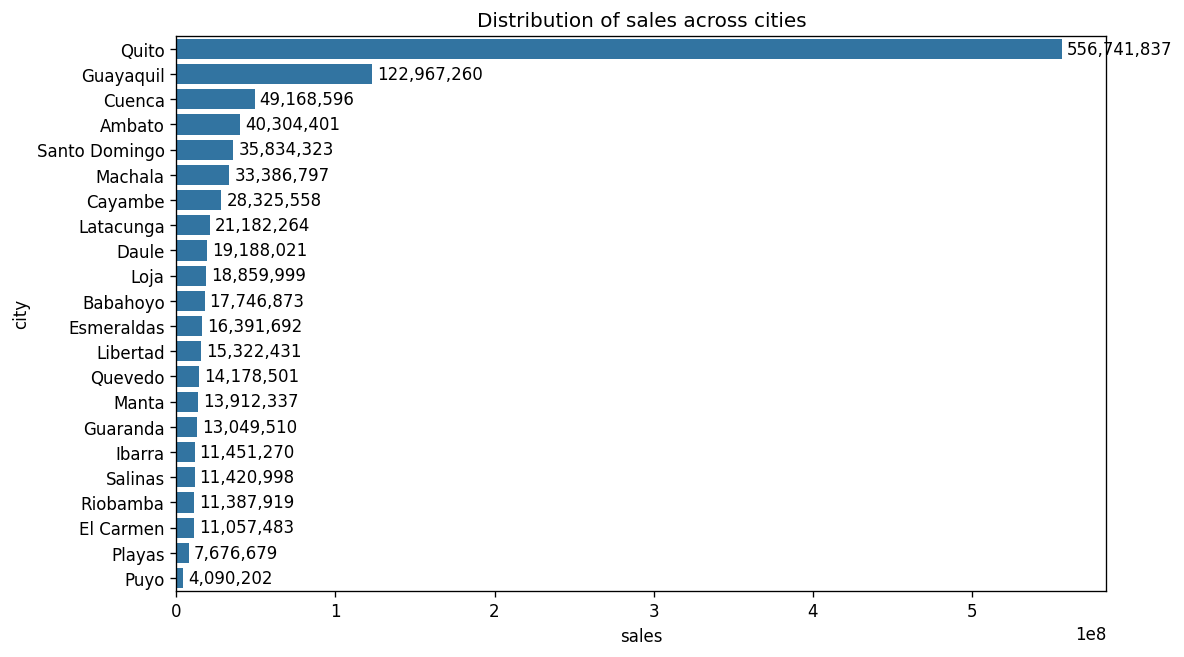

In [59]:
sales_by_cities=locations.groupby("city")["sales"].sum().reset_index().sort_values(by="sales", ascending=False)
sales_by_cities

## visualize the distribution of sales across cities
plt.figure(figsize=(10,6)) 
ax= sns.barplot( data= sales_by_cities, y='city', x='sales')
plt.title("Distribution of sales across cities")

for container in ax.containers:
    ax.bar_label(container,fmt='{:,.0f}',padding=3)
    
plt.show()

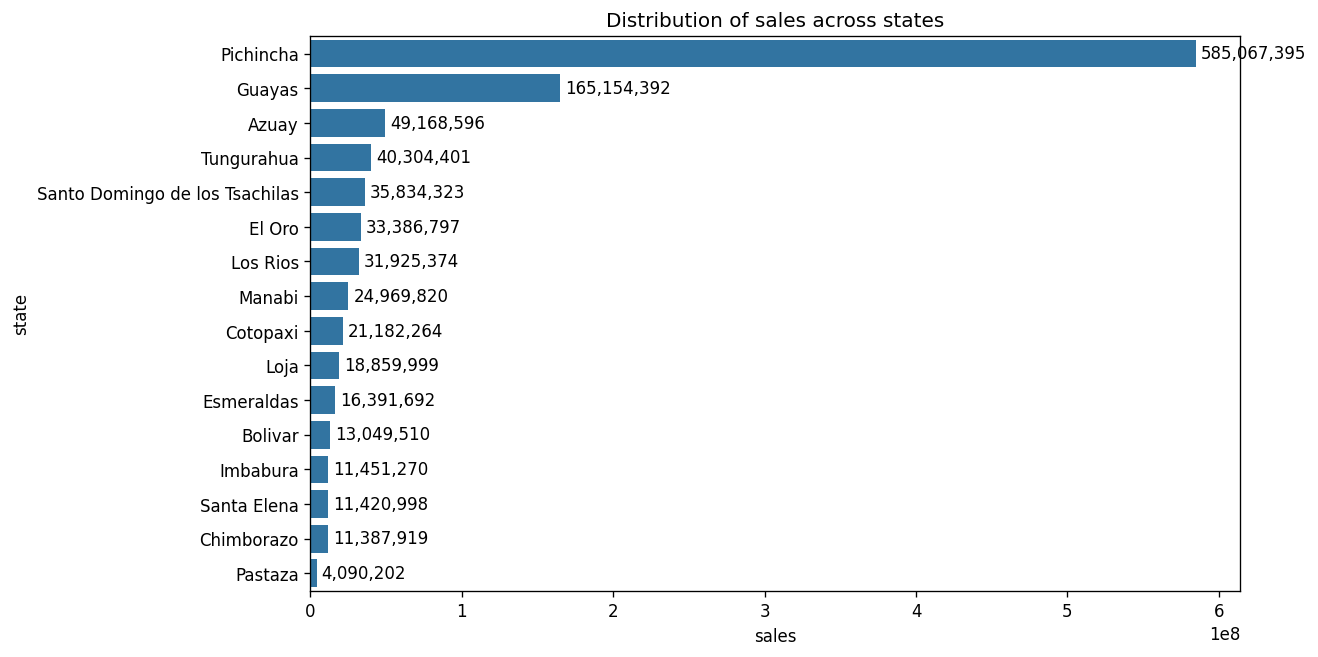

In [60]:
sales_by_states=locations.groupby("state")["sales"].sum().reset_index().sort_values(by="sales", ascending=False)

## visualize the distribution of sales across states
plt.figure(figsize=(10,6)) 
ax= sns.barplot(y='state', x='sales', data=sales_by_states)
plt.title("Distribution of sales across states")

for container in ax.containers:
    ax.bar_label(container,fmt='{:,.0f}',padding=3)
    
plt.show()

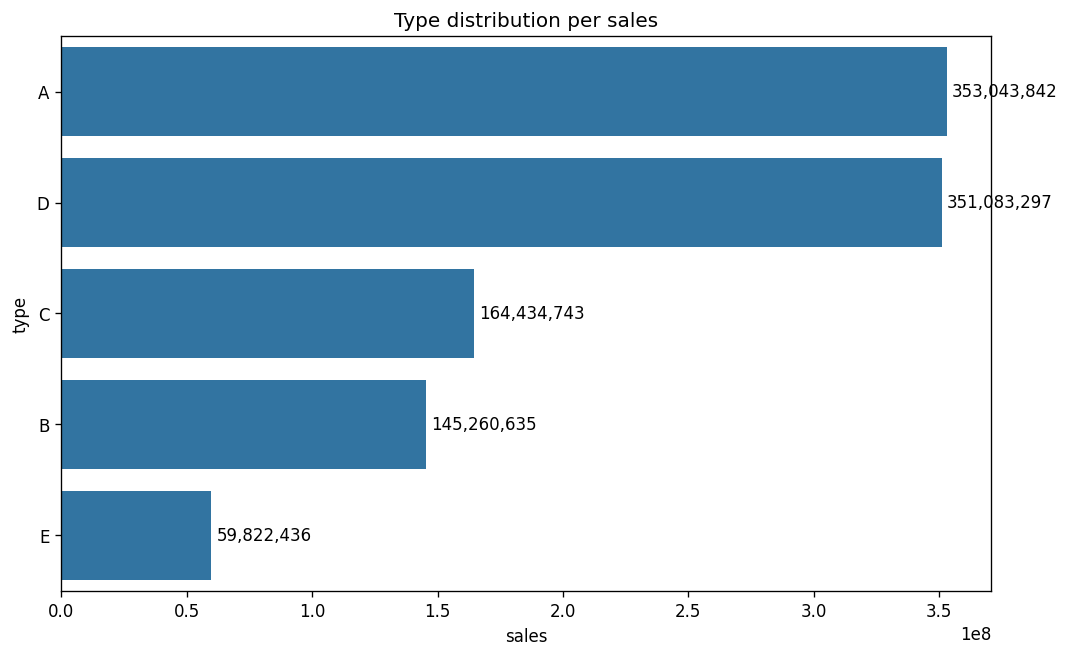

In [61]:
sales_by_typestore= locations.groupby("type")["sales"].sum().reset_index().sort_values(by="sales",ascending=False)

## visualize the distribution of sales across type of stores
plt.figure(figsize=(10,6))
ax= sns.barplot(y="type", x="sales", data=sales_by_typestore)
plt.title("Type distribution per sales")

for container in ax.containers:
    ax.bar_label(container,fmt='{:,.0f}',padding=3)
    
plt.show()

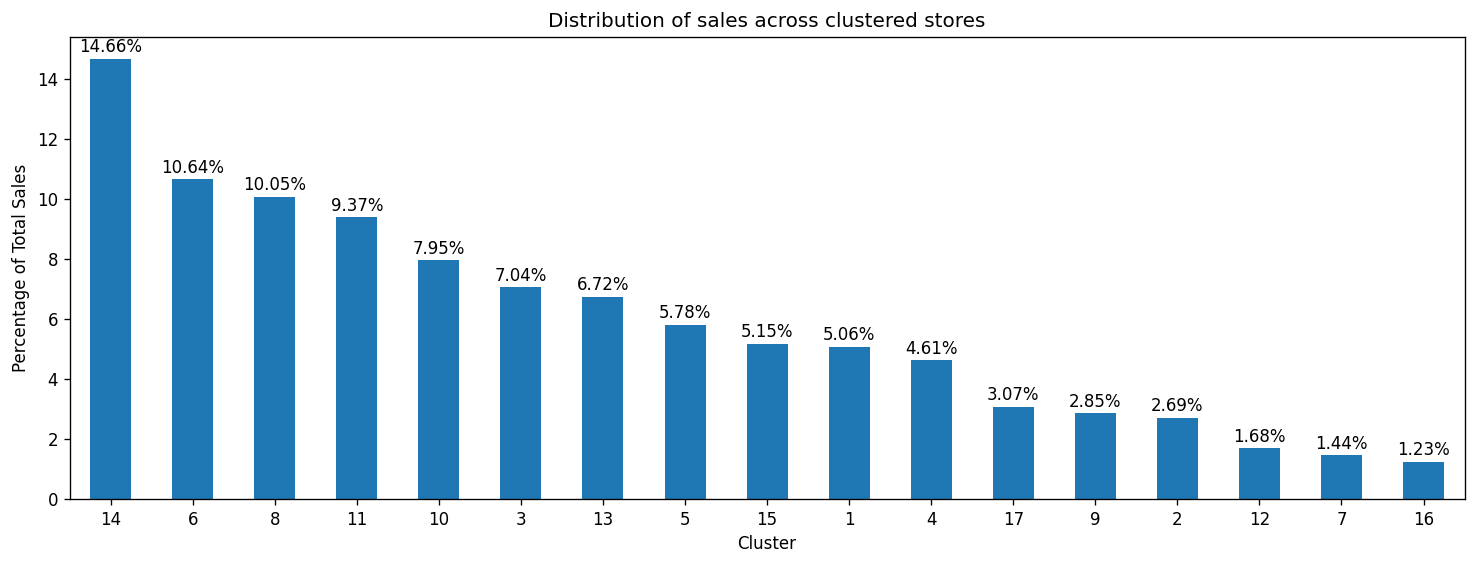

In [62]:
sales_by_cluster= locations.groupby("cluster")["sales"].sum().sort_values(ascending=False)

# Calculate overall total sales
overall_sales = locations['sales'].sum()

# Calculate the percentage of each cluster's sales over the overall sales
percentage_sales = (sales_by_cluster / overall_sales) * 100

## visualize the distribution of sales across clustered stores
# Plot a barplot to visualize the percentage of sales by cluster
plt.figure(figsize=(15, 5))
percentage_sales_sorted = percentage_sales.sort_values(ascending=False)
percentage_sales_sorted.plot.bar()

# Add labels to the bars
for i, percentage in enumerate(percentage_sales_sorted):
    plt.text(i, percentage + 0.1, f"{percentage:.2f}%", ha='center', va='bottom')

plt.title("Distribution of sales across clustered stores")   
plt.xlabel('Cluster')
plt.ylabel('Percentage of Total Sales')
plt.xticks(rotation=0)   
plt.show()

***REVIEW***

---- By city we can see that, stores located in Quito city had the highest sales across all stores in other cities 

---- By state we can see that, Pichincha state was leading in sales as compared to other states.

---- By type of store, type D are scattered further as compared to all other types following closely by type B and type A.

---- By cluster, stores clustered in level 5 were making more sales in comparison to other clustered stores.

**Q6 ARE SALES AFFECTED BY PROMOTIONS,OIL PRICES AND HOLIDAYS?**

In [63]:
new_merge= pd.merge(train_data,oil_data,how="left", left_index=True,right_index=True)
df_merged= pd.merge(new_merge,d2,how="left", left_index=True, right_index=True)

In [64]:
no_promotion= df_merged[df_merged["onpromotion"]==0]
promotions= df_merged[df_merged["onpromotion"]==1]
no_promotion_data= f"{no_promotion.shape[0]:,}"
promotion_data= f"{promotions.shape[0]:,}"
print(f"Number of datapoints with no promotion: {no_promotion_data}")
print(f"Number of datapoints with promotions: {promotion_data}")

Number of datapoints with no promotion: 2,435,656
Number of datapoints with promotions: 178,763


In [66]:
# Calculate correlations between sales and promotions, oil prices, holidays
corr_sales_promotions = df_merged['sales'].corr(df_merged['onpromotion'])
corr_sales_oil = df_merged['sales'].corr(df_merged['dcoilwtico'])
corr_sales_holidays = df_merged['sales'].corr(df_merged['type'] == 'Holiday')

# Print the correlation values
print(f"Correlation between Sales and Promotions: {corr_sales_promotions}")
print(f"Correlation between Sales and Oil Prices: {corr_sales_oil}")
print(f"Correlation between Sales and Holidays: {corr_sales_holidays}")

Correlation between Sales and Promotions: 0.4283271383765438
Correlation between Sales and Oil Prices: nan
Correlation between Sales and Holidays: -0.0024186100394253487


***REVIEW*** 

--- From the above visualizations, we can see that there is a positive correlation between the daily oil prices and the sales.

--- With products on promotion, we can see that the number of promotions ranging from 0- 250 motivated alot of people to buy products hence increase in the sales ratio.Howerver as the number of promotions increases, there is a decrease in sales ratio. This could be factored by the dates and months and events.

--- From our analysis we can see that the type of day has contributed to sales with additionals seemingly to be scattered further as compared to holidays.  

**Q7 WHAT ANALYSIS CAN WE GET FROM THE DATE AND ITS EXTRACTABLE FEATURES**

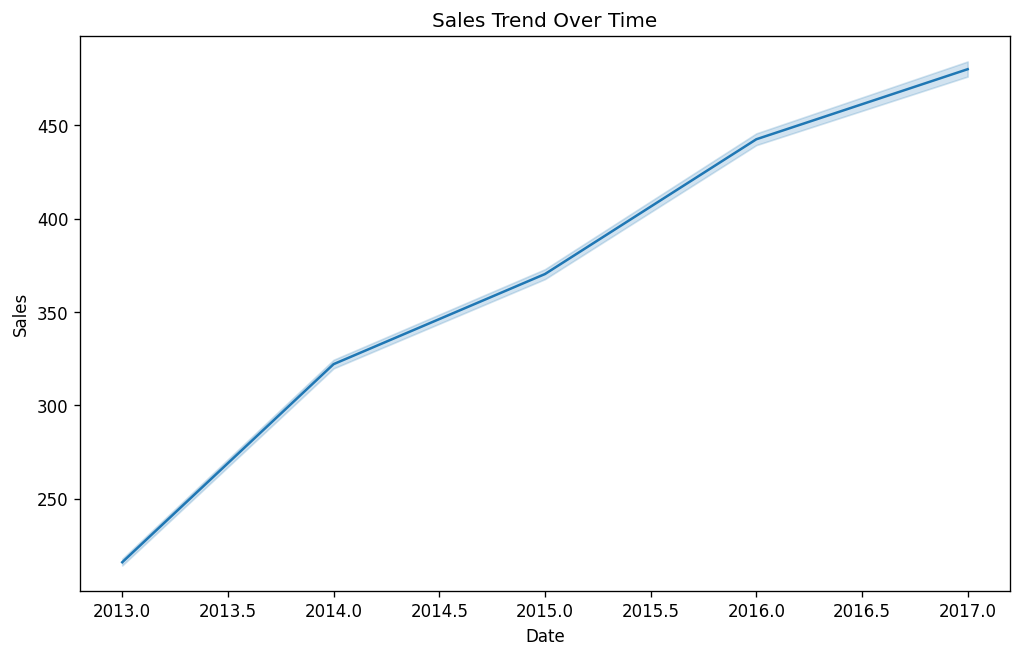

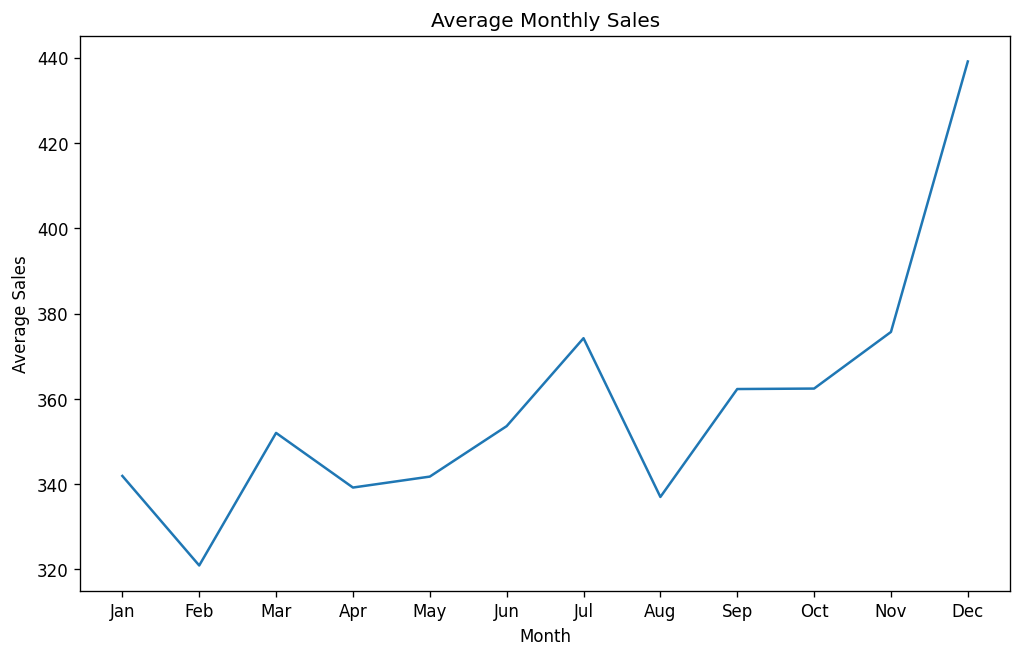

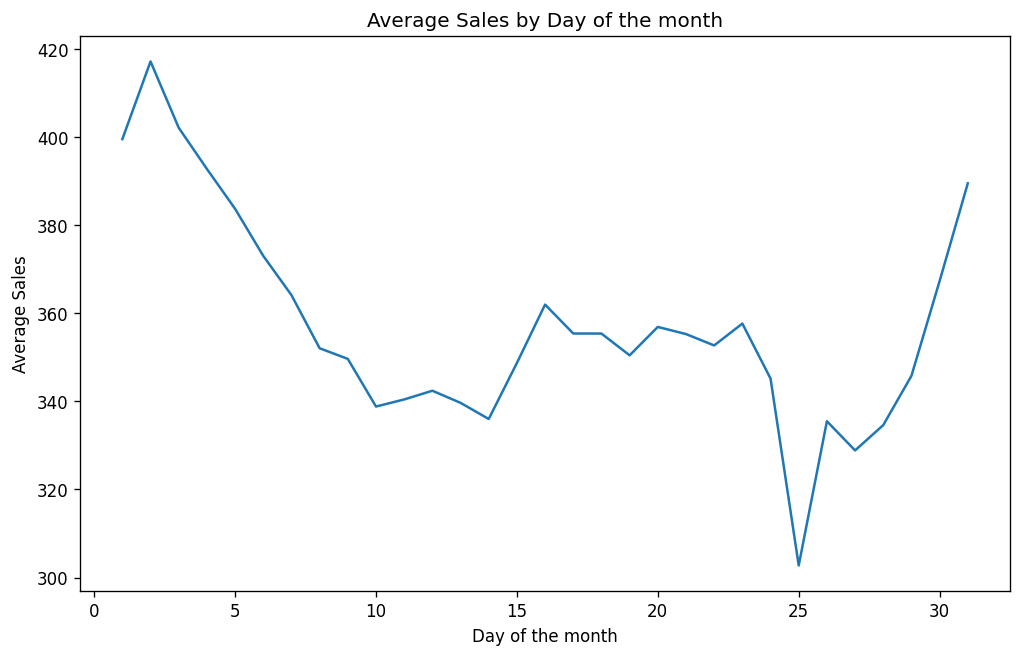

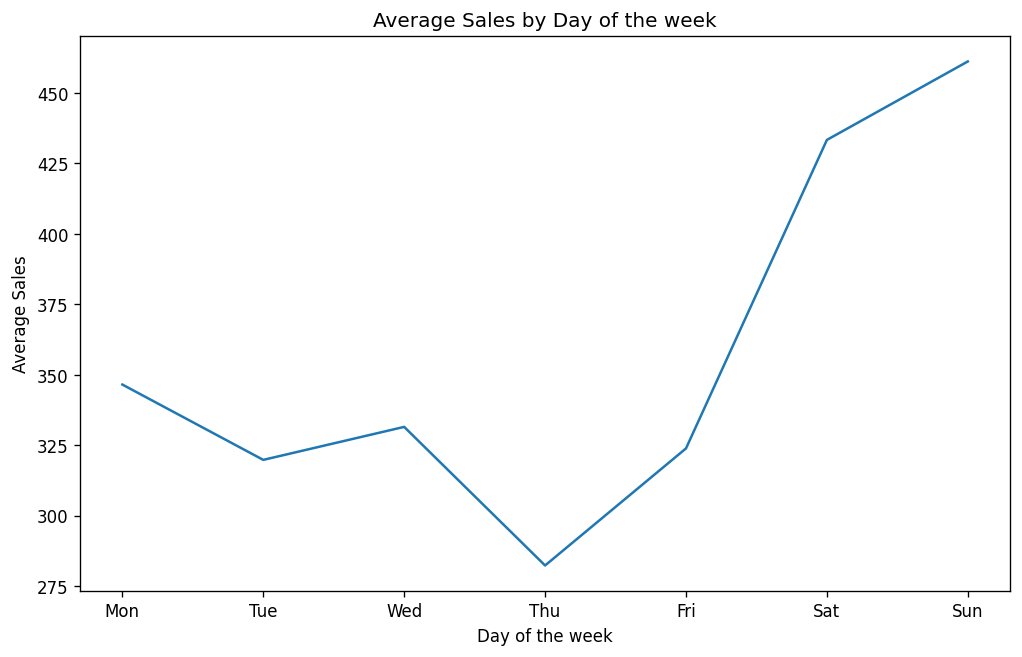

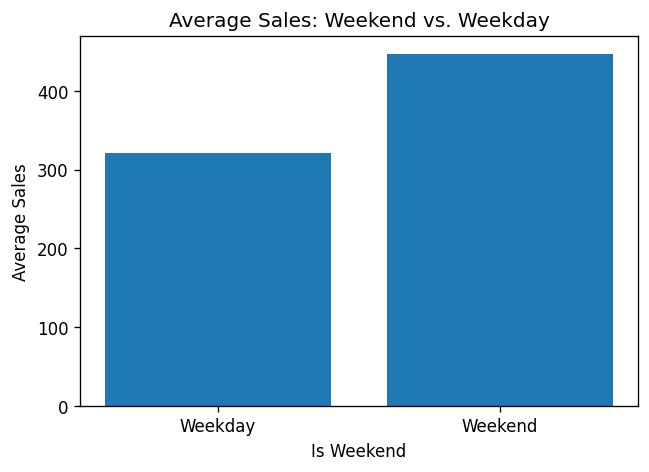

In [67]:
# Trend Analysis
plt.figure(figsize=(10, 6))
sns.lineplot(x="year", y='sales',data=df)
plt.title('Sales Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

# Seasonal Patterns (Monthly)
monthly_sales = df.groupby('month')['sales'].mean()
plt.figure(figsize=(10, 6))
plt.plot(monthly_sales.index, monthly_sales.values)
plt.title('Average Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

# Day of the month Analysis
day_of_month_sales = df.groupby('dayofmonth')['sales'].mean()
plt.figure(figsize=(10, 6))
plt.plot(day_of_month_sales.index, day_of_month_sales.values)
plt.title('Average Sales by Day of the month')
plt.xlabel('Day of the month')
plt.ylabel('Average Sales')
plt.show()

# Day of the week Analysis
day_of_week_sales = df.groupby('dayoftheweek')['sales'].mean()
plt.figure(figsize=(10, 6))
plt.plot(day_of_week_sales.index, day_of_week_sales.values)
plt.title('Average Sales by Day of the week')
plt.xlabel('Day of the week')
plt.ylabel('Average Sales')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

# Is Weekend Analysis
weekend_sales = df.groupby('Is_Weekend')['sales'].mean()
plt.figure(figsize=(6, 4))
plt.bar(weekend_sales.index, weekend_sales.values)
plt.title('Average Sales: Weekend vs. Weekday')
plt.xlabel('Is Weekend')
plt.ylabel('Average Sales')
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.show()

***REVIEW***

--- In our extracted date features, we can deduce that there is an actual trend over time from 2013 to 2017 with an increasing rate of sales.

--- We can also see that there is a seasonal pattern in the sales with the highest sales in the month of December and the lowest sales in the month of February and August.

--- We can also see that there is a seasonal pattern in the sales with the highest sales at the start of the month on the 3rd day, dropping significantly towards 14th, on 15th there is a stud increase and on 27th to 30th there is an increase. 

--- By end of the week, people frequently shop from friday to the weekends, thursday showing low sales during the week. And we can also see that the weekend sales increase more than during the weekdays.

**Q8 WHICH PRODUCT FAMILY AND STORES DID THE PROMOTION AFFECT**

In [68]:
# Pivot the data to create a matrix of sales by product family and store
promo_matrix = train_data.pivot_table(values='onpromotion', index='store_nbr', columns='family')
promo_matrix

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,EGGS,FROZEN FOODS,GROCERY I,GROCERY II,HARDWARE,HOME AND KITCHEN I,HOME AND KITCHEN II,HOME APPLIANCES,HOME CARE,LADIESWEAR,LAWN AND GARDEN,LINGERIE,"LIQUOR,WINE,BEER",MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
store_nbr,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.01,0.00,0.13,9.40,0.00,1.73,0.07,5.56,5.33,5.70,2.84,0.91,17.52,0.03,0.00,0.32,0.45,0.00,1.57,0.00,0.27,0.02,0.61,0.00,4.98,1.83,0.04,0.00,3.51,0.24,17.90,0.01,0.78
2,0.01,0.00,0.17,11.00,0.00,2.13,0.13,6.82,6.01,7.36,3.05,1.14,21.17,0.05,0.00,0.38,0.41,0.00,1.87,0.00,0.24,0.03,0.64,0.00,5.41,2.44,0.06,0.01,4.16,0.26,17.95,0.01,0.80
3,0.01,0.00,0.23,12.63,0.00,2.21,0.15,7.90,6.92,7.89,3.35,1.47,24.77,0.05,0.00,0.67,0.65,0.00,2.15,0.00,0.36,0.07,0.83,0.00,5.95,3.14,0.07,0.01,4.33,0.28,17.88,0.03,0.91
4,0.01,0.00,0.16,11.14,0.00,1.99,0.06,6.77,6.26,6.70,2.99,1.17,20.92,0.04,0.00,0.38,0.30,0.00,1.73,0.00,0.25,0.02,0.59,0.00,5.33,2.41,0.05,0.01,3.98,0.25,15.82,0.01,0.69
5,0.01,0.00,0.15,10.91,0.00,1.98,0.12,7.57,6.27,7.37,2.63,1.16,22.11,0.04,0.00,0.55,0.41,0.00,1.98,0.00,0.09,0.03,0.62,0.00,3.95,2.69,0.02,0.01,2.49,0.25,14.50,0.05,0.52
6,0.01,0.00,0.20,12.20,0.00,2.18,0.11,7.78,6.69,7.95,3.25,1.35,24.90,0.04,0.00,0.56,0.51,0.00,2.04,0.00,0.17,0.07,0.68,0.00,5.78,2.86,0.06,0.01,4.27,0.27,15.75,0.02,0.87
7,0.01,0.00,0.14,11.13,0.00,1.95,0.13,6.55,6.03,6.29,3.07,1.08,19.95,0.04,0.00,0.44,0.46,0.00,1.88,0.00,0.36,0.03,0.66,0.00,5.25,2.29,0.04,0.01,3.83,0.26,18.40,0.02,0.84
8,0.00,0.00,0.20,12.02,0.00,2.14,0.10,7.05,6.74,7.70,3.28,1.30,22.32,0.03,0.00,0.50,0.59,0.00,2.01,0.00,0.27,0.05,0.72,0.00,5.98,2.66,0.07,0.01,4.15,0.27,19.49,0.01,0.84
9,0.07,0.00,0.27,10.59,0.00,7.12,0.01,9.06,13.16,8.33,2.34,2.15,24.95,0.16,0.00,0.82,0.30,0.00,3.02,0.02,0.11,0.04,0.49,0.00,2.21,3.70,0.04,0.03,2.22,0.95,12.27,0.25,0.41


In [69]:
# Split Promoted items and those that were not promoted
new_data['onpromotion_encoded'] = np.where(new_data['onpromotion'] >= 1, 1, 0)
new_data['onpromotion_encoded'].value_counts()

onpromotion_encoded
0    2396687
1     611329
Name: count, dtype: int64

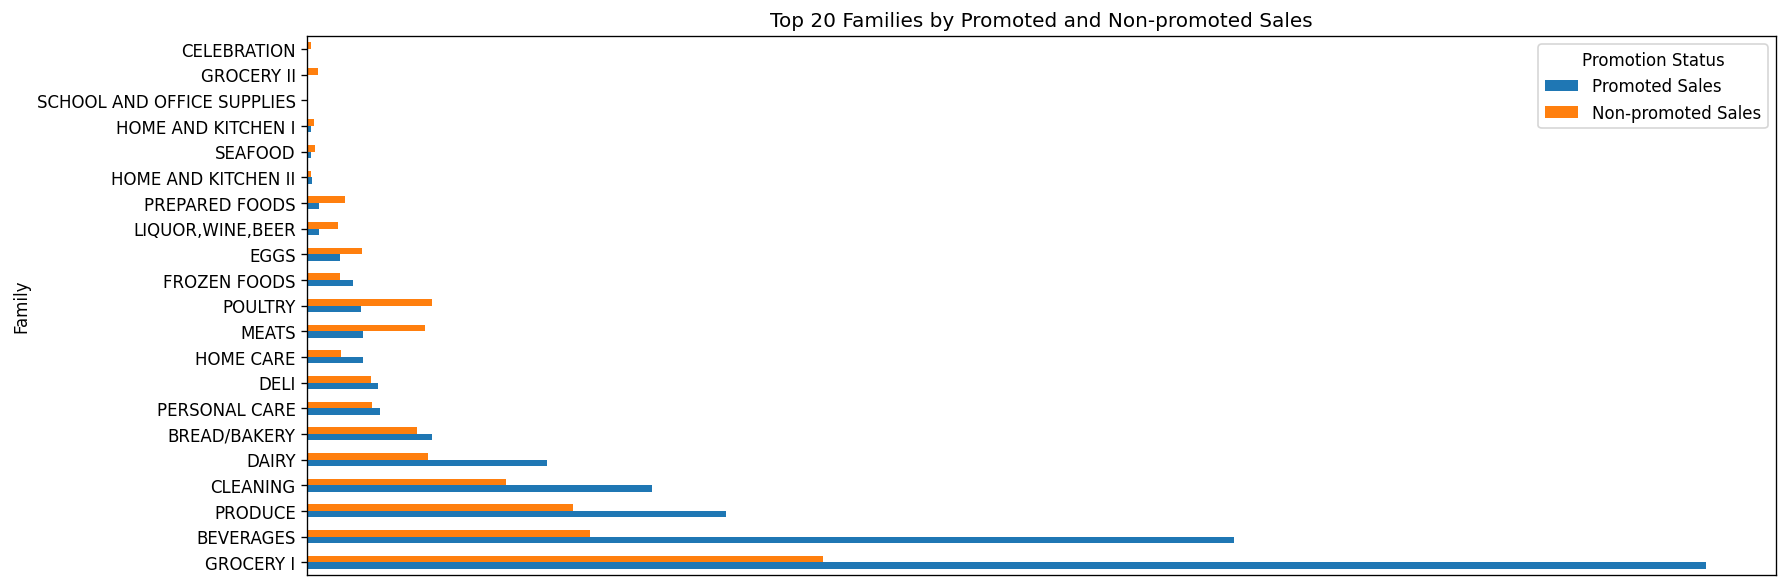

In [70]:
# Filter the DataFrame to include only rows where onpromotion_encoded is equal to 1
promoted_data = new_data[new_data['onpromotion_encoded'] == 1]
non_promoted_data = new_data[new_data['onpromotion_encoded'] == 0]

# Group by the family column and sum up the sales for each group, then sort the result
grouped_sales_promotion = promoted_data.groupby('family')['sales'].sum().sort_values(ascending=False).head(20)
non_promoted_data_grp = non_promoted_data.groupby('family')['sales'].sum().sort_values(ascending=False).head(20)

# Rename columns for clarity
grouped_sales_promotion = grouped_sales_promotion.rename('Promoted Sales')
non_promoted_data_grp = non_promoted_data_grp.rename('Non-promoted Sales')

# Convert the result to a DataFrame
grouped_sales_promotion = pd.concat([grouped_sales_promotion, non_promoted_data_grp], axis=1)

# Plotting
grouped_sales_promotion.plot(kind='barh', figsize=(15, 5))
plt.title('Top 20 Families by Promoted and Non-promoted Sales')
plt.ylabel('Family')
plt.xticks([])
plt.legend(title='Promotion Status')
plt.tight_layout()
plt.show()

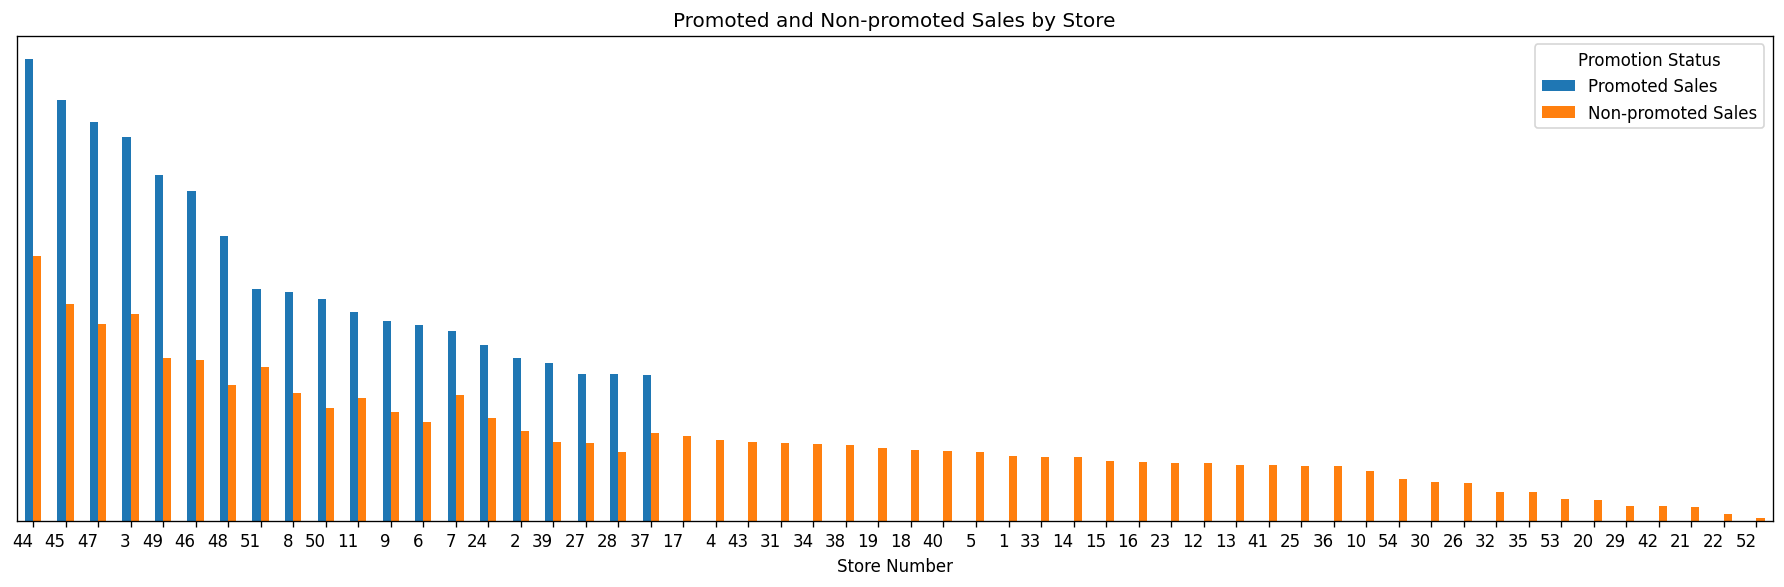

In [71]:
# Group by the family column and sum up the sales for each group, then sort the result
grouped_sales_promotion_str = promoted_data.groupby('store_nbr')['sales'].sum().sort_values(ascending=False).head(20)
non_promoted_data_grp_str = non_promoted_data.groupby('store_nbr')['sales'].sum().sort_values(ascending=False)

# Rename columns for clarity
grouped_sales_promotion_str = grouped_sales_promotion_str.rename('Promoted Sales')
non_promoted_data_grp_str = non_promoted_data_grp_str.rename('Non-promoted Sales')

# Convert the result to a DataFrame
grouped_sales_promotion_str = pd.concat([grouped_sales_promotion_str, non_promoted_data_grp_str], axis=1)

# Plotting
grouped_sales_promotion_str.plot(kind='bar', figsize=(15, 5))
plt.title('Promoted and Non-promoted Sales by Store')
plt.xlabel('Store Number')
plt.yticks([])
plt.xticks(rotation=0, ha='right')
plt.legend(title='Promotion Status')
plt.tight_layout()
plt.show()

***REVIEW*** 

--- We can see from the above visualizations that grocery 1 is the most promoted product in all the stores, with store 44 holding the most promoted products in their stores. Followed by produce products having an influence of sales by being promoted.

--- To note that the two product families are perishable goods hence, when promoted they signficantly increase the sales of the stores as they are consumed daily.

**Q9 DOES THE PAYMENT OF WAGES IN THE PUBLIC SECTOR ON THE 15TH AND THE LAST DAYS OF THE MONTH INFLUENCE THE STORE SALES**

Total average wage payment 342.8824305016479
Total average sales non wage payments 357.7749046341029


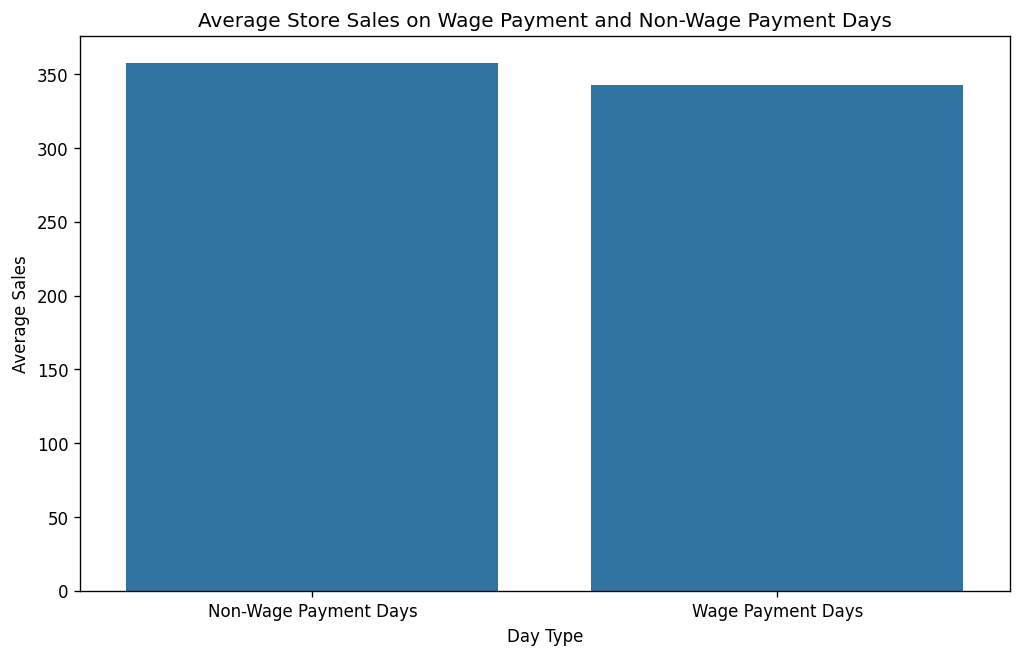

In [72]:
# Step 3: Create a new column 'Wage_Payment'
# Assuming wage payments are on the 15th and last day of each month
wage_payment_dates = [f'{year}-{month}-15' for year in range(2013, 2017) for month in range(1, 13)] + \
                     [f'{year}-{month}-{calendar.monthrange(year, month)[1]}' for year in range(2013, 2017) for month in range(1, 13)]

new_data['Wage_Payment'] = new_data.index.isin(wage_payment_dates).astype(int)

# Step 4: Calculate average sales for wage payment and non-wage payment days
avg_sales_wage_payment = new_data[new_data['Wage_Payment'] == 1]['sales'].mean()
avg_sales_non_wage_payment = new_data[new_data['Wage_Payment'] == 0]['sales'].mean()

## Print summary
print("Total average wage payment", avg_sales_wage_payment)
print("Total average sales non wage payments", avg_sales_non_wage_payment)

# Step 5: Visualize the results
plt.figure(figsize=(10, 6))
sns.barplot(x=['Non-Wage Payment Days', 'Wage Payment Days'], y=[avg_sales_non_wage_payment, avg_sales_wage_payment])
plt.title('Average Store Sales on Wage Payment and Non-Wage Payment Days')
plt.xlabel('Day Type')
plt.ylabel('Average Sales')
plt.show()

***REVIEW***

--- We can see that the average sales on wage payment days is closer to the average non-wage payment days. However, due to more purchases happening on the weekends, the average sales on wage payment does have a minimal impact but yet significant in the overall sales.

#### **HYPOTHESIS**

*NULL HYPOTHESIS* - 
Promotional activities does not have a significant effect on store sales

*ALTERNATIVE HYPOTHESIS* - 
Promotional activities does have a significant effect on store sales

In [73]:
# Get sales data for items on promotion and not on promotion
sales_on_promotion = new_data[new_data['onpromotion_encoded'] == 1]['sales']
sales_not_on_promotion = new_data[new_data['onpromotion_encoded'] == 0]['sales']

# Calculate means of sales
mean_sales_on_promotion = sales_on_promotion.mean()
mean_sales_not_on_promotion = sales_not_on_promotion.mean()

print(f"Mean of sales on promotion: {mean_sales_on_promotion}")
print(f"Mean of sales not on promotion: {mean_sales_not_on_promotion}")

Mean of sales on promotion: 1137.6937303133943
Mean of sales not on promotion: 157.7760390673924


In [74]:
# t-test hypothesis
stat, p = ttest_ind(train_data["sales"], train_data["onpromotion"])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Promotional activites does not affect sales, fail to reject the null hypothesis')
else:
	print('Promotional activities does affect sales,Reject the null hypothesis')

stat=558.217, p=0.000
Promotional activities does affect sales,Reject the null hypothesis


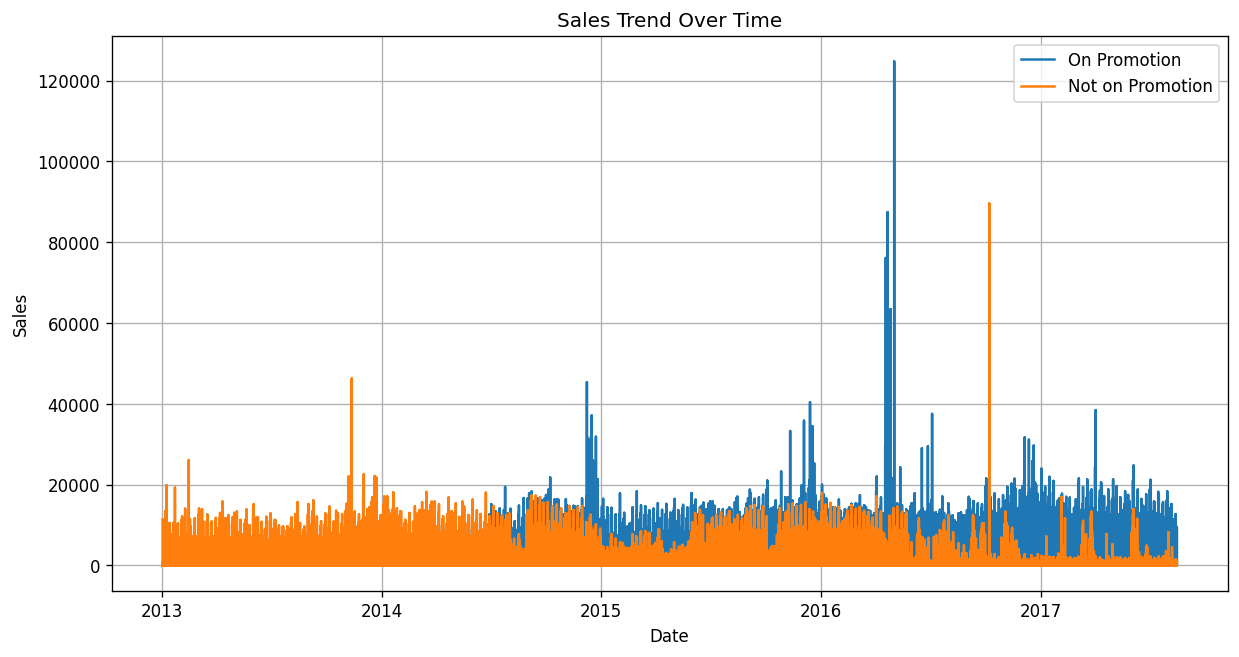

In [75]:
# Plot sales trend over time for items on promotion and items not on promotion
plt.figure(figsize=(12, 6))
plt.plot(new_data[new_data['onpromotion_encoded'] == 1].index, sales_on_promotion, label='On Promotion')
plt.plot(new_data[new_data['onpromotion_encoded'] == 0].index, sales_not_on_promotion, label='Not on Promotion')
plt.title('Sales Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

***REVIEW***

--- We can see that the p-value is less than 0.05, hence we can reject the null hypothesis and conclude that promotional activities does have a significant effect on store sales.

--- We can also see that sales are dependent on promotional activities,from our correlation analysis. Which attest to the fact that promotional activities do infact affect store sales significantly.

### **DATA CLEANING AND PREPROCESSING**

In [76]:
## Clean the family column by clustering the data
def reclassify_family(train):
    train["family"].replace(to_replace={'GROCERY I', 'GROCERY II','PRODUCE','PREPARED FOODS','DELI', 'EGGS','DAIRY','POULTRY','BREAD/BAKERY','FROZEN FOODS','MEATS','SEAFOOD'},value="Food_items", inplace=True)
    train["family"].replace(to_replace={'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES','PLAYERS AND ELECTRONICS'}, value="Kitchen_appliances", inplace=True)
    train["family"].replace(to_replace={'HOME CARE','LAWN AND GARDEN','PET SUPPLIES','CLEANING'}, value="Home and garden", inplace=True)
    train["family"].replace(to_replace={'SCHOOL AND OFFICE SUPPLIES','MAGAZINES','BOOKS','CELEBRATION'}, value="Stationary", inplace=True)
    train["family"].replace(to_replace={'BEAUTY','LINGERIE','PERSONAL CARE','LADIESWEAR','BABY CARE'}, value="Personal items", inplace=True)
    train["family"].replace(to_replace={'LIQUOR,WINE,BEER','BEVERAGES'}, value="Beverages and Liquor", inplace=True)
    train["family"].replace(to_replace={'AUTOMOTIVE','HARDWARE',}, value="Auto and Hardware", inplace=True)
    
reclassify_family(train_data)

In [78]:
## group your data to daily data
train_df= train_data.groupby(["family", pd.Grouper(freq="D")]).agg({"sales":"sum", 
                                                                     "onpromotion":"sum",
                                                                    }).reset_index()
train_df

,family,date,sales,onpromotion
0,Auto and Hardware,2013-01-01,0.00,0.00
1,Auto and Hardware,2013-01-02,301.00,0.00
2,Auto and Hardware,2013-01-03,198.00,0.00
3,Auto and Hardware,2013-01-04,226.00,0.00
4,Auto and Hardware,2013-01-05,429.00,0.00
...,...,...,...,...
11811,Stationary,2017-08-11,4893.00,144.00
11812,Stationary,2017-08-12,4976.00,150.00
11813,Stationary,2017-08-13,4732.00,150.00
11814,Stationary,2017-08-14,3877.00,154.00


In [79]:
train_df= train_df.set_index("date")
train_df= create_features(train_df)

**MAKE SERIES STATIONARY**

In [80]:
## Dataset for statistical models
## Convert the data into a daily summations
train= train_data["sales"].resample("D").sum().rename("Total_sales").reset_index()
train= train.set_index("date")
train

,Total_sales
date,
2013-01-01,2511.62
2013-01-02,496092.42
2013-01-03,361461.23
2013-01-04,354459.68
2013-01-05,477350.12
...,...
2017-08-11,826373.72
2017-08-12,792630.54
2017-08-13,865639.68


In [81]:
def make_stationary(data):
    return data.diff().dropna()

# Making the time series stationary
train["sale_diff"] = make_stationary(train["Total_sales"])

In [82]:
# train_data= train_data.set_index("date")
## Downsample the data to weekly averages
wkly_sales = train["sale_diff"].resample('W').mean() # resample weekly and calculate mean
print(wkly_sales)

## Check if the data is stationary
t_stat, p_value, critical_values, _, _ = zivot_andrews(wkly_sales.values)
print(f'Zivot-Andrews Statistic: {t_stat:.2f}')
for key, value in critical_values.items():
     print('Critial Values:')
     print(f'   {key}, {value:.2f}')

print(f'\np-value: {p_value:.2f}')
print("Non-Stationary") if p_value > 0.05 else print("Stationary")

date
2013-01-06   103436.76
2013-01-13    -7865.26
2013-01-20     -506.59
2013-01-27    -4382.91
2013-02-03     7989.26
                ...   
2017-07-23   -10930.71
2017-07-30    14209.11
2017-08-06   -10599.04
2017-08-13   -26274.21
2017-08-20   -51488.87
Freq: W-SUN, Name: sale_diff, Length: 242, dtype: float64
Zivot-Andrews Statistic: -6.37
Critial Values:
   1%, -5.28
Critial Values:
   5%, -4.81
Critial Values:
   10%, -4.57

p-value: 0.00
Stationary


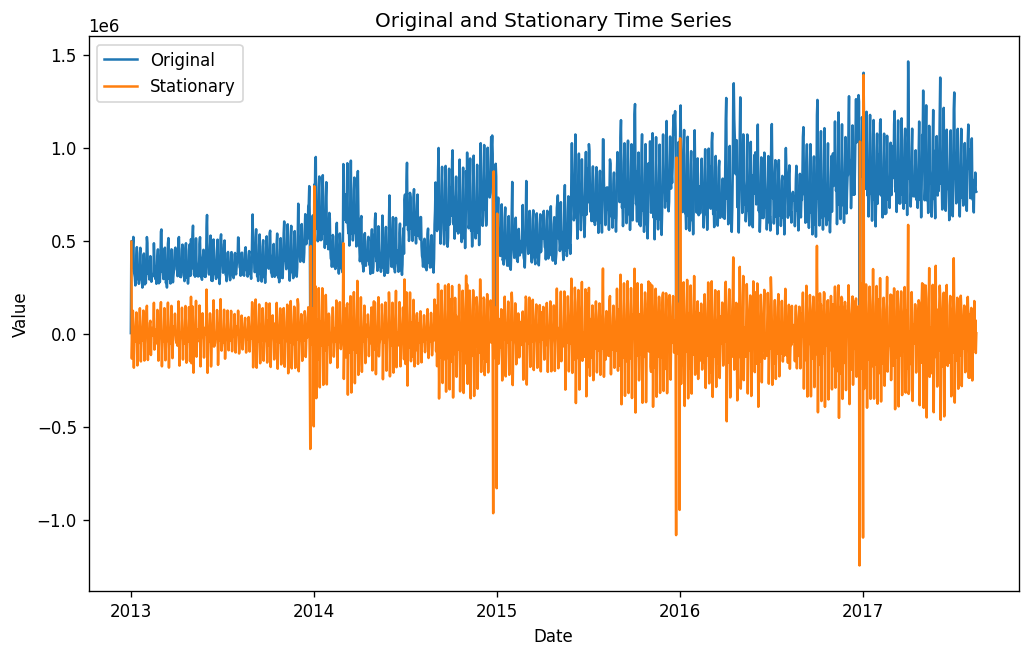

In [83]:
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Total_sales'], label='Original')
plt.plot(train.index, train["sale_diff"], label='Stationary')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Original and Stationary Time Series')
plt.legend()
plt.show()

**DATASET SPLITTING**

DATA SPLITTING FOR STATISTICAL MODELS

In [84]:
## Drop missing values
train= train.dropna()

In [85]:
## DATA SPLITING
split_date= "2017-06-01"

train_set= train.loc[train.index < split_date]
test_set= train.loc[train.index >= split_date]

print("Training set shape:", train_set.shape)
print("Testing set shape:", test_set.shape)

Training set shape: (1611, 2)
Testing set shape: (76, 2)


DATA SPLITING FOR TRADITIONAL MODELS

In [86]:
# Split the data into training and testing sets
train_size = int(0.9 * len(train_df)) 
trained_set= train_df.iloc[:train_size]
tested_set= train_df.iloc[train_size:]

## split the data
X_train= trained_set.drop(columns=["sales"])
y_train= trained_set["sales"]
X_test= tested_set.drop(columns=["sales"])
y_test= tested_set["sales"]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (10634, 8)
y_train shape: (10634,)
X_test shape: (1182, 8)
y_test shape: (1182,)


In [87]:
#Get numerical columns
numerical_columns=X_train.select_dtypes('number').columns
# numerical_columns=X_t.select_dtypes('number').columns

## Categorical columns
categorical_columns=X_train.select_dtypes('object').columns
# categorical_columns=X_test.select_dtypes('object').columns

In [88]:
# prepare numerical pipeline
numerical_pipeline=Pipeline(steps=[
('numerical_imputer',SimpleImputer(strategy='median')),
('scaler', StandardScaler())
    
])

# prepare categorical pipeline
categorical_pipeline=Pipeline(steps=[
    ('categorical_imputer',SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())
])
    

# Column transformer preparation
preprocessor=ColumnTransformer(transformers=[
    ('numerical_pipeline', numerical_pipeline,numerical_columns),
    ('categorical_pipeline', categorical_pipeline, categorical_columns)
])

### **MODELLING**

## **AUTOREG MODEL**

In [89]:
model = AutoReg(train_set["sale_diff"], lags=7)
model_fit = model.fit()
model= model_fit.summary()
warnings.filterwarnings("default")
model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              sale_diff   No. Observations:                 1611
Model:                     AutoReg(7)   Log Likelihood              -20931.137
Method:               Conditional MLE   S.D. of innovations         112465.128
Date:                Mon, 27 May 2024   AIC                          41880.273
Time:                        19:51:05   BIC                          41928.695
Sample:                    01-09-2013   HQIC                         41898.252
                         - 05-31-2017                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1009.9044   2808.460      0.360      0.719   -4494.575    6514.384
sale_diff.L1    -0.4947      0.024    -20.417      0.000      -0.542      -0.447
sale_diff.L2    -0.5603      0.026    -21.867      0.000      -0.611      -0.510
sale_diff.L3    -0.4855      0.026    -18.416      0.000      -0.537      -0.434
sale_diff.L4    -0.4728      0.027    -17.820      0.000      -0.525      -0.421
sale_diff.L5    -0.5002      0.026    -18.947      0.000      -0.552      -0.448
sale_diff.L6    -0.3663      0.026    -14.279      0.000      -0.417      -0.316
sale_diff.L7     0.2406      0.024      9.935      0.000       0.193       0.288
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0075           -0.4838j            1.1177           -0.4288
AR.2           -1.0075           +0.4838j            1.1177            0.4288
AR.3           -0.2438           -1.0268j            1.0554           -0.2871
AR.4           -0.2438           +1.0268j            1.0554            0.2871
AR.5            0.6527           -0.8200j            1.0481           -0.1430
AR.6            0.6527           +0.8200j            1.0481            0.1430
AR.7            2.7197           -0.0000j            2.7197           -0.0000
-----------------------------------------------------------------------------
"""

In [90]:
## Predict the outcome
Forecast = model_fit.predict(start=len(train_set["sale_diff"]), 
                             end=len(train_set["sale_diff"])+len(test_set["sale_diff"])-1, 
                             dynamic=False)

## Evaluate model using the metrics
mse = mean_squared_error(test_set["sale_diff"], Forecast)
mae = mean_absolute_error(test_set["sale_diff"],Forecast)
rmse = np.sqrt(mse).round(2)
result=pd.DataFrame([["AR",mse,mae,rmse]], columns=["model_fit", "mse","mae","rmse",])
result

c:\Users\user\Desktop\corporation favorita\Time-forecast-prediction\myenv\lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


,model_fit,mse,mae,rmse
0,AR,22681231322.68,123638.27,150602.89


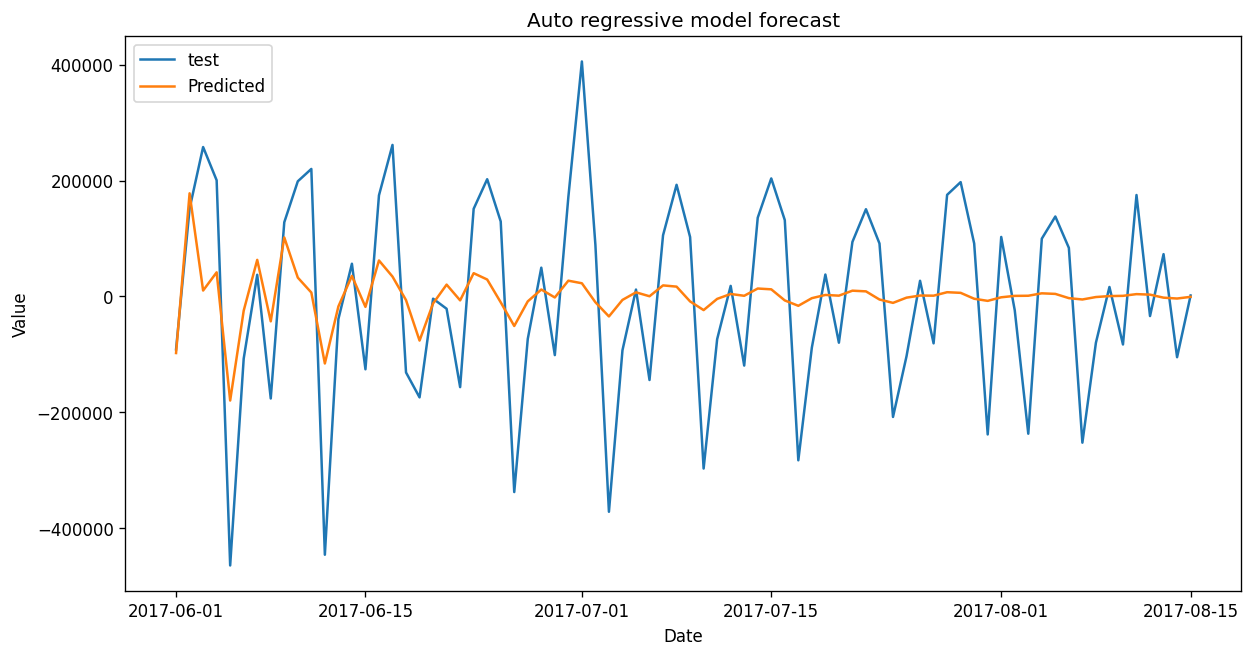

In [91]:
## Visualize results
plt.figure(figsize=(12, 6))
plt.plot(test_set.index, test_set["sale_diff"], label='test')
plt.plot(Forecast, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc="upper left")
plt.title("Auto regressive model forecast")
plt.show()

## **ARIMA MODEL**

In [92]:
## Check for the best parameters
step_wise_fit= auto_arima(train_set["sale_diff"],
                          trace=True,
                          seasonal=True,
                          m=7,
                          stepwise=True,
                          suppress_warnings=True)

step_wise_fit.summary()

Performing stepwise search to minimize aic


 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=42057.199, Time=20.83 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=43417.174, Time=0.34 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=42663.540, Time=5.34 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=42820.905, Time=6.44 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=43415.189, Time=0.19 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=42383.043, Time=19.30 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=inf, Time=31.89 sec
 ARIMA(2,0,2)(2,0,1)[7] intercept   : AIC=42047.940, Time=37.29 sec
 ARIMA(2,0,2)(2,0,0)[7] intercept   : AIC=42126.570, Time=33.19 sec
 ARIMA(2,0,2)(2,0,2)[7] intercept   : AIC=inf, Time=64.82 sec
 ARIMA(2,0,2)(1,0,2)[7] intercept   : AIC=42040.786, Time=34.48 sec
 ARIMA(2,0,2)(0,0,2)[7] intercept   : AIC=42245.112, Time=36.97 sec
 ARIMA(1,0,2)(1,0,2)[7] intercept   : AIC=42092.256, Time=43.51 sec
 ARIMA(2,0,1)(1,0,2)[7] intercept   : AIC=42300.449, Time=40.36 sec
 ARIMA(3,0,2)(1,0,2)[7] intercept   : AIC=42033.991, Time=54.92 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1611
Model:             SARIMAX(4, 0, 2)x(1, 0, 2, 7)   Log Likelihood              -20968.060
Date:                           Mon, 27 May 2024   AIC                          41958.119
Time:                                   20:22:59   BIC                          42017.350
Sample:                               01-02-2013   HQIC                         41980.106
                                    - 05-31-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1449.6908    730.299      1.985      0.047      18.330    2881.051
ar.L1         -1.5765      0.105    -15.084      0.000      -1.781      -1.372
ar.L2         -1.0869      0.158     -6.867      0.000      -1.397      -0.777
ar.L3         -0.5993      0.085     -7.062      0.000      -0.766      -0.433
ar.L4         -0.2260      0.037     -6.159      0.000      -0.298      -0.154
ma.L1          1.0814      0.108     10.024      0.000       0.870       1.293
ma.L2          0.2203      0.113      1.950      0.051      -0.001       0.442
ar.S.L7        0.9935      0.003    329.432      0.000       0.988       0.999
ma.S.L7       -0.7493      0.020    -37.377      0.000      -0.789      -0.710
ma.S.L14      -0.1586      0.021     -7.531      0.000      -0.200      -0.117
sigma2      1.342e+10      0.001   1.97e+13      0.000    1.34e+10    1.34e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):            105141.19
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               4.27   Skew:                            -2.44
Prob(H) (two-sided):                  0.00   Kurtosis:                        42.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.82e+27. Standard errors may be unstable.
"""

In [93]:
# Fit an ARIMA model with differencing order 1 (i.e., first difference)
model = ARIMA(train_set["sale_diff"], order=(4, 0, 2))
model_ARIMA = model.fit()
warnings.filterwarnings("default")
model_ARIMA.summary()

c:\Users\user\Desktop\corporation favorita\Time-forecast-prediction\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\user\Desktop\corporation favorita\Time-forecast-prediction\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\user\Desktop\corporation favorita\Time-forecast-prediction\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              sale_diff   No. Observations:                 1611
Model:                 ARIMA(4, 0, 2)   Log Likelihood              -21420.831
Date:                Mon, 27 May 2024   AIC                          42857.661
Time:                        20:24:17   BIC                          42900.738
Sample:                    01-02-2013   HQIC                         42873.652
                         - 05-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        531.0677    255.814      2.076      0.038      29.682    1032.453
ar.L1         -0.4741      0.022    -21.663      0.000      -0.517      -0.431
ar.L2          0.0799      0.021      3.872      0.000       0.039       0.120
ar.L3         -0.2649      0.023    -11.405      0.000      -0.310      -0.219
ar.L4         -0.1164      0.022     -5.258      0.000      -0.160      -0.073
ma.L1         -0.0003      0.022     -0.013      0.989      -0.043       0.042
ma.L2         -0.8212      0.022    -37.953      0.000      -0.864      -0.779
sigma2      1.343e+10   1.59e-05   8.43e+14      0.000    1.34e+10    1.34e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):              3027.09
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               3.29   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.79e+30. Standard errors may be unstable.
"""

In [94]:
fc = model_ARIMA.predict(start=len(train_set["sale_diff"]), end=len(train_set["sale_diff"])+len(test_set["sale_diff"])-1, dynamic=False)

## Evaluate model using the metrics
mse = mean_squared_error(test_set["sale_diff"], fc)
mae = mean_absolute_error(test_set["sale_diff"],fc)
rmse = np.sqrt(mse).round(1)

scores=pd.DataFrame([["ARIMA",mse,mae,rmse]], columns=["model_fit", "mse","mae","rmse"])
results= pd.concat([result,scores], axis=0, ignore_index=True)
results

,model_fit,mse,mae,rmse
0,AR,22681231322.68,123638.27,150602.89
1,ARIMA,30149564474.13,142407.08,173636.30


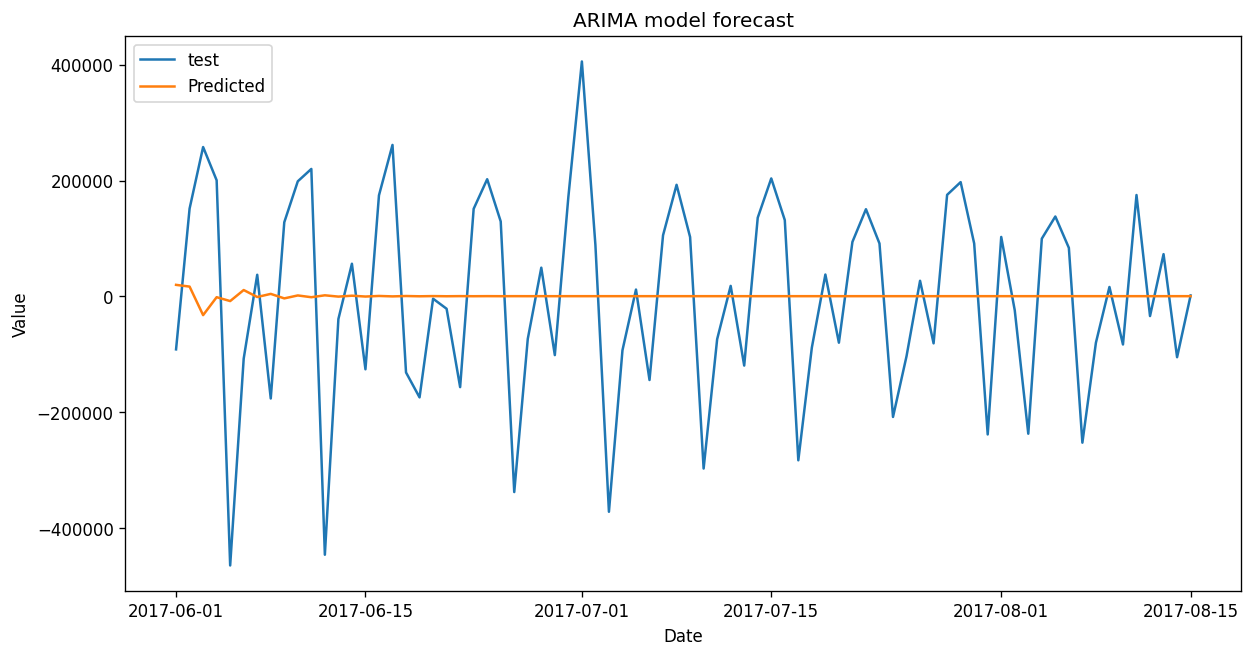

In [95]:
## Visualize results
plt.figure(figsize=(12, 6))
plt.plot(test_set.index, test_set["sale_diff"], label='test')
plt.plot(fc, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc="upper left")
plt.title("ARIMA model forecast")
plt.show()

## **SARIMA MODEL**

In [96]:
# Fit an SARIMA model with differencing order 1 
model = SARIMAX(train_set["sale_diff"], order=(4, 0, 2),seasonal_order=(1,0,2,7))
model_SARIMA = model.fit()
warnings.filterwarnings("default")
model_SARIMA.summary()

c:\Users\user\Desktop\corporation favorita\Time-forecast-prediction\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\user\Desktop\corporation favorita\Time-forecast-prediction\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\user\Desktop\corporation favorita\Time-forecast-prediction\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                         sale_diff   No. Observations:                 1611
Model:             SARIMAX(4, 0, 2)x(1, 0, 2, 7)   Log Likelihood              -20902.794
Date:                           Mon, 27 May 2024   AIC                          41825.589
Time:                                   20:26:34   BIC                          41879.435
Sample:                               01-02-2013   HQIC                         41845.577
                                    - 05-31-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5763      0.022    -26.524      0.000      -0.619      -0.534
ar.L2          0.5191      0.022     23.230      0.000       0.475       0.563
ar.L3          0.2291      0.021     11.173      0.000       0.189       0.269
ar.L4          0.1163      0.026      4.518      0.000       0.066       0.167
ma.L1         -0.0069      0.024     -0.289      0.773      -0.054       0.040
ma.L2         -0.9930      0.014    -69.358      0.000      -1.021      -0.965
ar.S.L7        0.9975      0.002    593.507      0.000       0.994       1.001
ma.S.L7       -0.6707      0.013    -51.036      0.000      -0.696      -0.645
ma.S.L14      -0.2430      0.020    -11.860      0.000      -0.283      -0.203
sigma2      1.343e+10   2.24e-12      6e+21      0.000    1.34e+10    1.34e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):             80070.28
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               4.22   Skew:                            -1.80
Prob(H) (two-sided):                  0.00   Kurtosis:                        37.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.61e+36. Standard errors may be unstable.
"""

In [97]:
y_pred = model_SARIMA.predict(start=len(train_set["sale_diff"]), end=len(train_set["sale_diff"])+len(test_set["sale_diff"])-1, dynamic=False)

## Evaluate model using the metrics
mse = mean_squared_error(test_set["sale_diff"], y_pred)
mae = mean_absolute_error(test_set["sale_diff"],y_pred)
rmse = np.sqrt(mse).round(1)

score=pd.DataFrame([["SARIMAX",mse,mae,rmse]], columns=["model_fit", "mse","mae" ,"rmse"])
results= pd.concat([results, score], axis=0, ignore_index=True)
results

,model_fit,mse,mae,rmse
0,AR,22681231322.68,123638.27,150602.89
1,ARIMA,30149564474.13,142407.08,173636.30
2,SARIMAX,7000279839.40,60390.66,83667.70


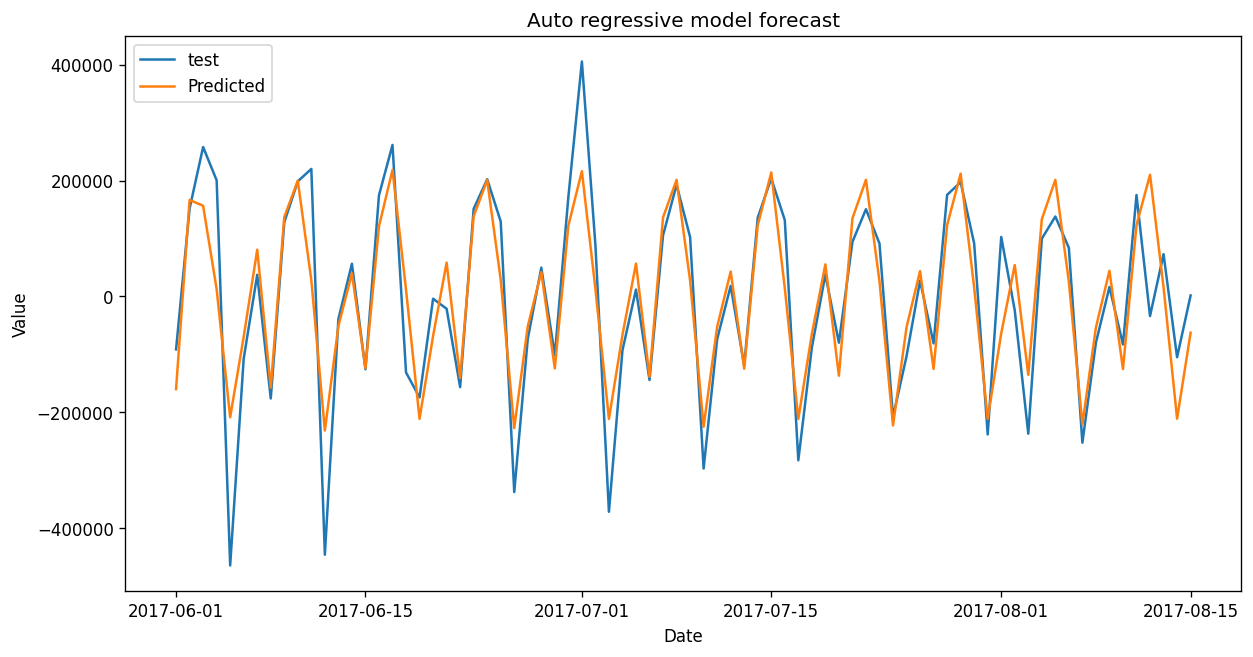

In [98]:
## Visualize results
plt.figure(figsize=(12, 6))
plt.plot(test_set.index, test_set["sale_diff"], label='test')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc="upper left")
plt.title("Auto regressive model forecast")
plt.show()

## **XGBOOST MODEL**

In [99]:
## fit the model into a pipeline
xgb_pipeline=Pipeline(steps=[
        ('preprocessor', preprocessor),
        ("xgb", XGBRegressor(objective='reg:squarederror', n_estimators=100))
])

In [100]:
# Train the model
xgb_pipeline.fit(X_train, y_train)

# Make predictions on the testing set
pred = xgb_pipeline.predict(X_test)

# Evaluate the model using mean squared error
mse = mean_squared_error(y_test, pred)
mae= mean_absolute_error(y_test, pred)
rmse= np.sqrt(mse).round(2)
metrics= pd.DataFrame([["XGB", mse, mae, rmse,]], columns=["model_fit", "mse", "mae","rmse",])
metrics
results= pd.concat([results,metrics], axis=0, ignore_index=True)
results

,model_fit,mse,mae,rmse
0,AR,22681231322.68,123638.27,150602.89
1,ARIMA,30149564474.13,142407.08,173636.30
2,SARIMAX,7000279839.40,60390.66,83667.70
3,XGB,6784032.18,1678.91,2604.62


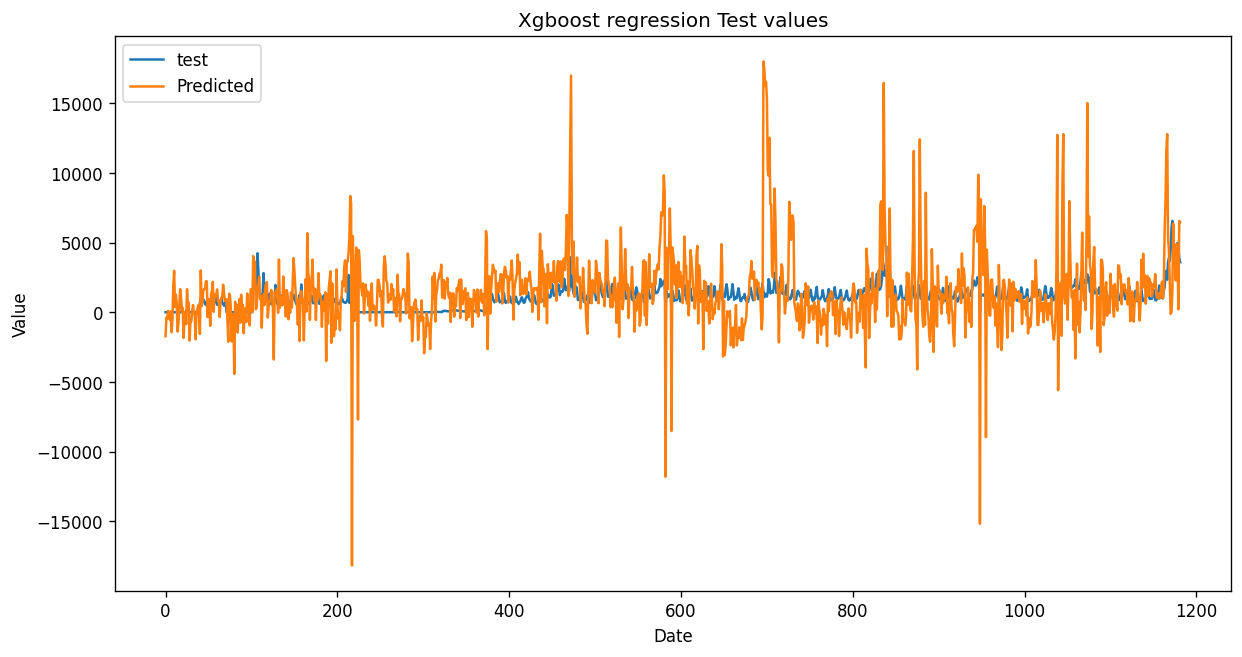

In [101]:
## Visualize results
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='test')
plt.plot(pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc="upper left")
plt.title("Xgboost regression Test values")
plt.show()

## **LIGHTGBM REGRESSION**

In [102]:
## fit the model into a pipeline
lgbm_pipeline=Pipeline(steps=[
        ('preprocessor', preprocessor),
        ("lgbm", LGBMRegressor(boosting_type="gbdt", num_leaves=31, metrics="binary_logloss"))
])

In [103]:
# Train the model
lgbm_pipeline.fit(X_train, y_train)

# Make predictions on the testing set
pred = lgbm_pipeline.predict(X_test)

# Evaluate the model using mean squared error
mse = mean_squared_error(y_test, pred)
mae= mean_absolute_error(y_test, pred)
rmse= np.sqrt(mse).round(2)
lgbtable= pd.DataFrame([["lgbm", mse, mae, rmse]], columns=["model_fit", "mse", "mae", "rmse"])
lgbtable
results= pd.concat([results,lgbtable], axis=0, ignore_index=True)
results

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 333
[LightGBM] [Info] Number of data points in the train set: 10634, number of used features: 13
[LightGBM] [Info] Start training from score 100845.410543


,model_fit,mse,mae,rmse
0,AR,22681231322.68,123638.27,150602.89
1,ARIMA,30149564474.13,142407.08,173636.30
2,SARIMAX,7000279839.40,60390.66,83667.70
3,XGB,6784032.18,1678.91,2604.62
4,lgbm,21817747.95,2380.60,4670.95


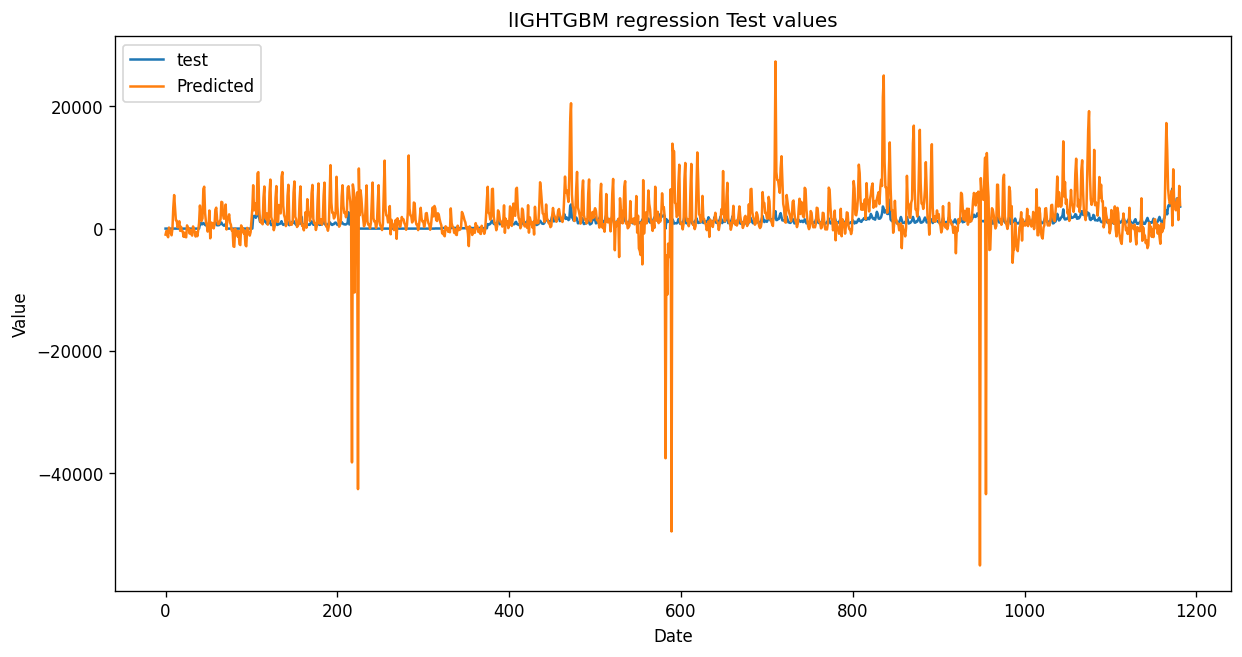

In [104]:
## Visualize results
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='test')
plt.plot(pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc="upper left")
plt.title("lIGHTGBM regression Test values")
plt.show()

## **LINEAR REGRESSION**

In [105]:
## Fit the pipeline with the regression model
lg_pipeline=Pipeline(steps=[
        ('preprocessor', preprocessor),
        ("linear",LinearRegression())])

In [106]:
# Train the model
lg_pipeline.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = lg_pipeline.predict(X_test)

# Evaluate the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
mae= mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Mean Squared Error: {mse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root mean squared Error: { rmse:.2f}')

metric= pd.DataFrame([["linear", mse, mae, rmse]], columns=["model_fit", "mse", "mae", "rmse"])
results= pd.concat([results, metric],axis=0, ignore_index=True)
results

Mean Squared Error: 911454743.76
Mean Absolute Error: 26194.73
Root mean squared Error: 30190.31


,model_fit,mse,mae,rmse
0,AR,22681231322.68,123638.27,150602.89
1,ARIMA,30149564474.13,142407.08,173636.30
2,SARIMAX,7000279839.40,60390.66,83667.70
3,XGB,6784032.18,1678.91,2604.62
4,lgbm,21817747.95,2380.60,4670.95
5,linear,911454743.76,26194.73,30190.31


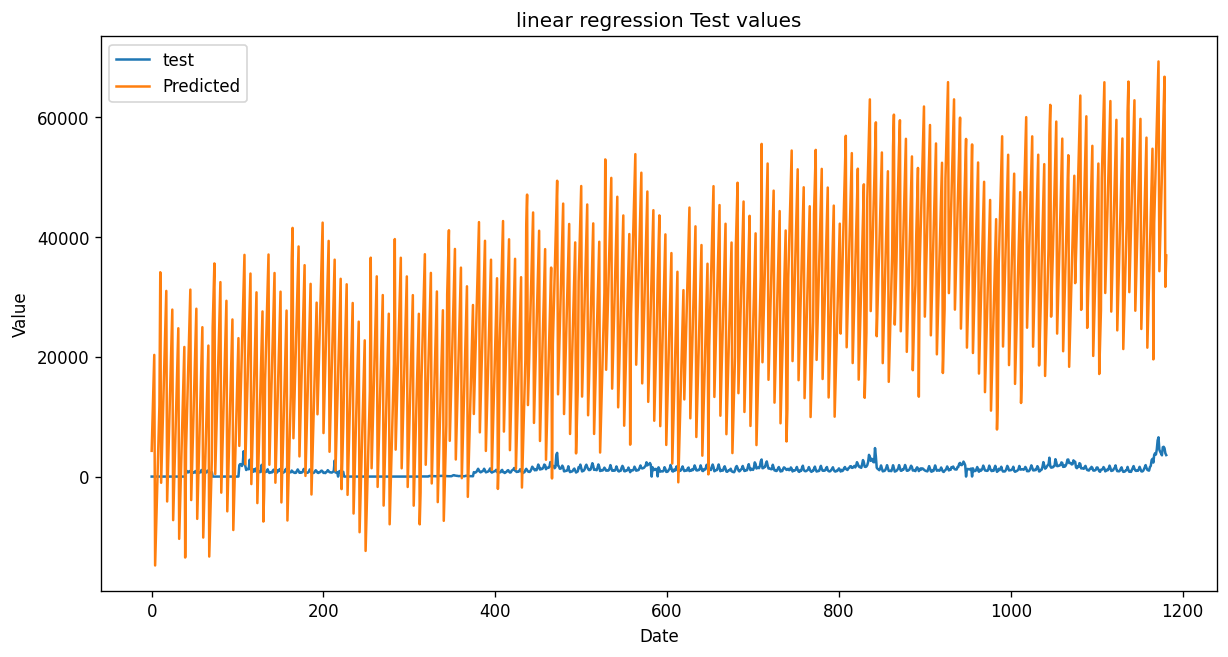

In [107]:
## Visualize results
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='test')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc="upper left")
plt.title("linear regression Test values")
plt.show()

***REVIEW***

--- Our models are fitting the model well. We can see that Xgboost is outstanding with the average distance between the observed values and predicted values of 2604.62. From the visualization we can see that it has been able to predict the sales values from 2017 onwards.

--- LGBM Regressor was the second best model with an RMSE score of 4670.95 and from its visualization we can easily see the model was able to predict on an accurate level.

--- In our statistical models, SARIMAX was the best model performing with an RMSE score of 83681.80 with its visualization showcasing its ability to predict sales over time on an accurate prediction.

--- Autoreg was the second best statistical model being able to predict with an RMSE score of 150602.89 and the visualization demonstrating the model being able to predict the first few yrs and months after which it slacked.

### **MODEL EVALUATION** 

In [108]:
## lets make sure that the data is a daily data
datatrain= train.asfreq("D")
datatrain
trained= datatrain["sale_diff"]
trained.head()

date
2013-01-02    493580.80
2013-01-03   -134631.19
2013-01-04     -7001.55
2013-01-05    122890.44
2013-01-06     42345.28
Freq: D, Name: sale_diff, dtype: float64

In [109]:
# Train-test dates
# ======================================================================================
end_train = '2017-06-01'
print(
    f"Train dates : {datatrain.index.min()} --- {datatrain.loc[:end_train].index.max()}  "
    f"(n={len(datatrain.loc[:end_train])})"
)
print(
    f"Test dates  : {datatrain.loc[end_train:].index.min()} --- {datatrain.loc[:].index.max()}  "
    f"(n={len(datatrain.loc[end_train:])})"
)
data_train = datatrain.loc[:end_train]
data_test  = datatrain.loc[end_train:]

Train dates : 2013-01-02 00:00:00 --- 2017-06-01 00:00:00  (n=1612)
Test dates  : 2017-06-01 00:00:00 --- 2017-08-15 00:00:00  (n=76)


***REVIEW***

--- Our model was able to predict the sales values accurately from jun, jul, aug of 2017 

### **HYPERPARAMETER TUNING**

**XGBOOSTER TUNING**

In [111]:
xgb_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'xgb', 'preprocessor__force_int_remainder_cols', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__numerical_pipeline', 'preprocessor__categorical_pipeline', 'preprocessor__numerical_pipeline__memory', 'preprocessor__numerical_pipeline__steps', 'preprocessor__numerical_pipeline__verbose', 'preprocessor__numerical_pipeline__numerical_imputer', 'preprocessor__numerical_pipeline__scaler', 'preprocessor__numerical_pipeline__numerical_imputer__add_indicator', 'preprocessor__numerical_pipeline__numerical_imputer__copy', 'preprocessor__numerical_pipeline__numerical_imputer__fill_value', 'preprocessor__numerical_pipeline__numerical_imputer__keep_empty_features', 'preprocessor__numerical_pipeline__numerical_imputer__missing_values', 'preprocessor__numerical

In [112]:
xgbmodel= xgb_pipeline.fit(X_train, y_train)

In [113]:
param_grid = {
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.1, 0.5, 1],
    'xgb__n_estimators': [100, 200, 300],
    'xgb__subsample': [0.5, 0.7, 1],
    
}

# Time series split
tscv = TimeSeriesSplit(n_splits=5)
scoring={"rmse":make_scorer(mean_squared_error, response_method="predict", greater_is_better=False)}
# Grid search
grid = GridSearchCV(estimator=xgbmodel,
                    param_grid=param_grid,
                    scoring=scoring,
                    cv=tscv,
                    verbose=1,
                    refit="rmse",
                    n_jobs=-1
                    )
grid.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
print("Best hyperparameters:", grid.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


c:\Users\user\Desktop\corporation favorita\Time-forecast-prediction\myenv\lib\site-packages\sklearn\model_selection\_search.py:1052: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best hyperparameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__subsample': 0.5}


In [115]:
## fit your best hyperparameters
predictions = grid.predict(X_test)
mse= mean_squared_error(y_test,predictions)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f'Mean Squared Error: {mse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root mean squared Error: { rmse:.2f}')

metrics_table= pd.DataFrame([["XGB", mse, mae, rmse]], columns=["model_fit", "mse", "mae", "rmse"])
metrics_table

Mean Squared Error: 64363852.71
Mean Absolute Error: 5936.11
Root mean squared Error: 8022.71


,model_fit,mse,mae,rmse
0,XGB,64363852.71,5936.11,8022.71


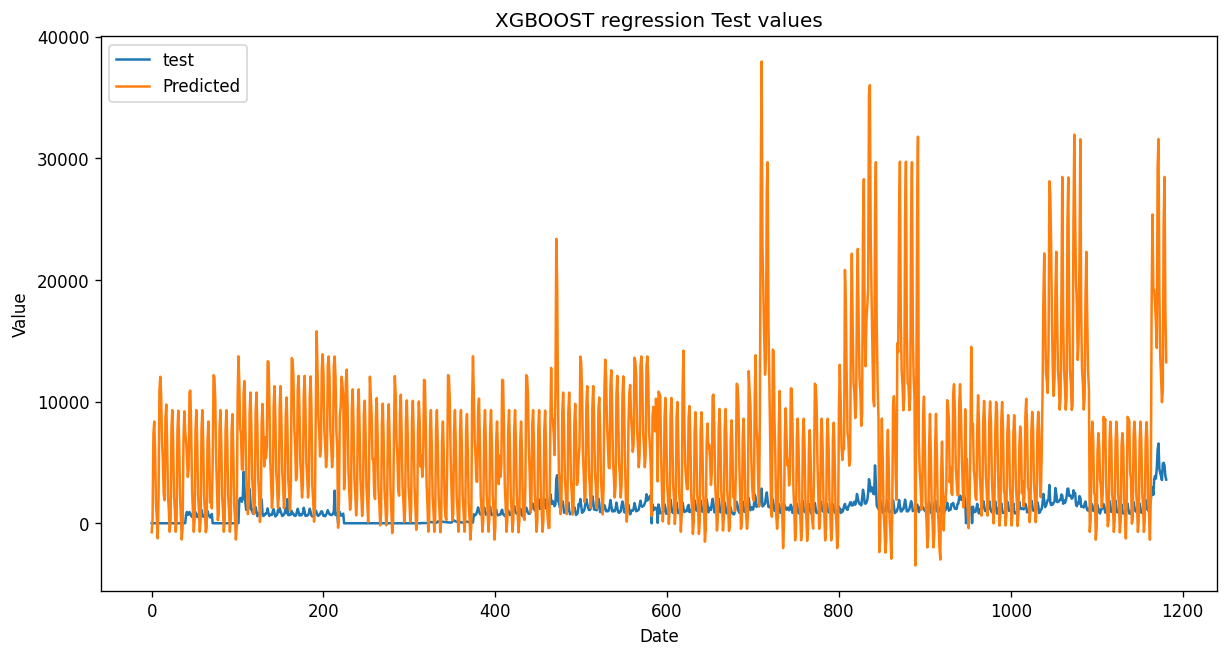

In [116]:
## Visualize results
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='test')
plt.plot(predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc="upper left")
plt.title("XGBOOST regression Test values")
plt.show()

We can see that our model Xgboost performed poorly that the intial test regression. Therefore, we shall retain the original model 

**FEATURE IMPORTANCE**

In [117]:
# Get the feature importances
importances = xgb_pipeline.named_steps['xgb'].feature_importances_

# Print the feature importances
print(importances)

## Generate features out 
features= xgb_pipeline.named_steps['preprocessor'].named_transformers_["categorical_pipeline"].named_steps["encoder"]
num_features= numerical_columns
cat_feat= features.get_feature_names_out(categorical_columns)
feature_names=  list(num_features) + list(cat_feat)
feature_names

[1.3628976e-02 6.0011628e-03 2.7553744e-03 0.0000000e+00 1.7832281e-03
 1.3826604e-02 2.0870888e-04 8.4853806e-02 8.2224286e-01 4.7836348e-02
 1.3467303e-04 6.6483701e-03 7.9996382e-05]


['onpromotion',
 'year',
 'month',
 'quater',
 'dayofmonth',
 'dayoftheweek',
 'family_Auto and Hardware',
 'family_Beverages and Liquor',
 'family_Food_items',
 'family_Home and garden',
 'family_Kitchen_appliances',
 'family_Personal items',
 'family_Stationary']

In [118]:
# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

feature_importances.sort_values(by="Importance", ascending=False)

,Feature,Importance
8,family_Food_items,0.82
7,family_Beverages and Liquor,0.08
9,family_Home and garden,0.05
5,dayoftheweek,0.01
0,onpromotion,0.01
11,family_Personal items,0.01
1,year,0.01
2,month,0.00
4,dayofmonth,0.00
6,family_Auto and Hardware,0.00


#### **TEST DATA**

In [122]:
test_data= pd.read_csv(r"Data\test.csv", parse_dates=["date"])
test_data.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [123]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.1+ MB


In [124]:
test_data.isna().sum()

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

In [125]:
test_data.duplicated().sum()

0

In [126]:
reclassify_family(test_data)

C:\Users\user\AppData\Local\Temp\ipykernel_23176\3392713194.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train["family"].replace(to_replace={'GROCERY I', 'GROCERY II','PRODUCE','PREPARED FOODS','DELI', 'EGGS','DAIRY','POULTRY','BREAD/BAKERY','FROZEN FOODS','MEATS','SEAFOOD'},value="Food_items", inplace=True)


In [127]:
test_data= test_data.set_index("date")

In [128]:
## group your data to daily data
new_test= test_data.groupby(["family", pd.Grouper(freq="D")]).agg({
                                                                     "onpromotion":"sum"
                                                                    }).reset_index()
new_test

,family,date,onpromotion
0,Auto and Hardware,2017-08-16,0
1,Auto and Hardware,2017-08-17,1
2,Auto and Hardware,2017-08-18,0
3,Auto and Hardware,2017-08-19,0
4,Auto and Hardware,2017-08-20,2
...,...,...,...
107,Stationary,2017-08-27,156
108,Stationary,2017-08-28,155
109,Stationary,2017-08-29,155
110,Stationary,2017-08-30,165


In [129]:
new_test=new_test.set_index("date")

In [130]:
new_test=create_features(new_test)

In [131]:
new_test.head()

,family,onpromotion,year,month,quater,dayofmonth,dayoftheweek,Is_Weekend
date,,,,,,,,
2017-08-16,Auto and Hardware,0,2017,8,3,16,2,False
2017-08-17,Auto and Hardware,1,2017,8,3,17,3,False
2017-08-18,Auto and Hardware,0,2017,8,3,18,4,False
2017-08-19,Auto and Hardware,0,2017,8,3,19,5,True
2017-08-20,Auto and Hardware,2,2017,8,3,20,6,True


In [132]:
loaded_model= joblib.load('toolkit\model.joblib')

predictions= loaded_model.predict(new_test)
predictions

<>:1: DeprecationWarning: invalid escape sequence '\m'
<>:1: DeprecationWarning: invalid escape sequence '\m'
C:\Users\user\AppData\Local\Temp\ipykernel_23176\3023706551.py:1: DeprecationWarning: invalid escape sequence '\m'
  loaded_model= joblib.load('toolkit\model.joblib')


array([2.5569404e+03, 4.6596542e+02, 1.6123987e+03, 8.6570563e+02,
       1.4398638e+03, 4.9390732e+02, 1.3222479e+02, 9.6129724e+02,
       6.8756020e+01, 1.3197593e+03, 8.8996039e+02, 5.3932733e+02,
       1.7004762e+03, 8.2324298e+02, 1.6694689e+03, 1.3320880e+03,
       1.6944244e+05, 1.5888736e+05, 1.8945284e+05, 2.2649606e+05,
       2.4061830e+05, 1.8981242e+05, 1.6221455e+05, 1.6166111e+05,
       1.5023147e+05, 1.7927312e+05, 2.1579889e+05, 2.3193572e+05,
       1.7473873e+05, 1.6333695e+05, 1.6810897e+05, 1.6251959e+05,
       5.2252353e+05, 4.0073031e+05, 4.8937131e+05, 5.2569319e+05,
       5.5804012e+05, 4.9427941e+05, 4.6481734e+05, 4.9172203e+05,
       3.9425825e+05, 4.9493725e+05, 5.2559112e+05, 5.5373188e+05,
       4.9031028e+05, 4.6116253e+05, 5.0785706e+05, 4.4905038e+05,
       7.9288695e+04, 7.2454211e+04, 7.1581297e+04, 8.9025531e+04,
       9.5192789e+04, 8.6293117e+04, 7.2212727e+04, 7.3925234e+04,
       6.9108969e+04, 6.8947250e+04, 8.9645164e+04, 9.4502867e

In [133]:
##Submission test
submission= pd.DataFrame({"sales_predictions":predictions}, index=new_test.index)
submission

,sales_predictions
date,
2017-08-16,2556.94
2017-08-17,465.97
2017-08-18,1612.40
2017-08-19,865.71
2017-08-20,1439.86
...,...
2017-08-27,4907.54
2017-08-28,7560.06
2017-08-29,4582.84
